# ***Historical style generator***

This notebook shows the process and orientation in building an Historical style generator.

This notebook was created for a bachelor's degree final project.

Students – ***Leor Ariel Rose***, ***Yahav Bar David***

Academic advisor - ***Dr. Irina Rabaev***

## ***Import Libraries***

In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from typing import List
from tensorflow import keras
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from google.colab import drive

## *** Data Exploration ***

In our data set we have variuos images lets explore the types and the representation.

### *** Hebrew Data ***

## ***PreProcess***

### ***  ***

### ***Define Util Methods***

Define two util methods the same way there are used in are document style transfer model.

tensor_to_image - function to transform tensor to an image.

load_img - function to load an image and limit its maximum dimension to 512 pixels.


In [2]:
def tensor_to_image(tensor: tf.Tensor) -> Image:
  """
  function to transform tensor to an image
  
  Args:
    tensor (tf.Tensor): tensor representing image

  Returns:
    PIL.Image: pillow image object
  """ 
  # multuply by 255 to undo normalization
  tensor = tensor*255
  # turn to array
  tensor: np.ndarray = np.array(tensor, dtype=np.uint8)
  # remove the array dimension, leave only image
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor: tf.Tensor = tensor[0]
  # return array from image
  return Image.fromarray(tensor)

In [3]:
def load_img(path_to_img: str) -> tf.Tensor:
  """
  Function to load an image and limit its maximum dimension to 512 pixels
  
  Args:
    path_to_img (str): image path
    
  Returns:
    tf.Tensor: a tensor that represents an image
  """
  # set max dimensions
  max_dim: int = 512
  # read document
  img: tf.Tensor = tf.io.read_file(path_to_img)
  # decode to image
  img: tf.Tensor = tf.image.decode_image(img, channels=3)
  # convert to float, each val between [0,1]
  img: tf.Tensor = tf.image.convert_image_dtype(img, tf.float32)

  # get image width and hieght
  shape: tf.Tensor = tf.cast(tf.shape(img)[:-1], tf.float32)
  # get max height or width
  long_dim: tf.Tensor= max(shape)
  # get the ratio scale to 512
  scale: tf.Tensor = max_dim / long_dim

  # get the nex image shape by scale ratio
  new_shape: tf.Tensor = tf.cast(shape * scale, tf.int32)

  # rezise image
  img: tf.Tensor = tf.image.resize(img, new_shape)
  
  # expand dimension to image array
  img: tf.Tensor = img[tf.newaxis, :]
  return img

---

# Create New Model
Define a new model that outputs a feature map from the convolutional layers.

In [4]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
vgg: tf.keras.Model = tf.keras.applications.VGG19(include_top=False, 
                                                  weights='imagenet')
  
# set model to not train itself
vgg.trainable = False

# define convolutional layers
outputs: List[str]= ['block1_conv1', 'block1_conv2', 'block2_conv1', 
                     'block2_conv2', 'block3_conv1', 'block3_conv2', 
                     'block3_conv3', 'block3_conv4', 'block4_conv1', 
                     'block4_conv2', 'block4_conv3', 'block4_conv4', 
                     'block5_conv1', 'block5_conv2', 'block5_conv3', 
                     'block5_conv4']

# create a new vgg modelfrom the convolutional layers
model: tf.keras.Model = tf.keras.Model([vgg.input], 
                                       [vgg.get_layer(name).output for 
                                        name in outputs])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

---

## Load Content Image

Load the content image

In [5]:
content_img_path = '/content/content.png'
content_img: tf.Tensor = load_img(content_img_path)
content_img.shape

TensorShape([1, 358, 512, 3])

Preprocess content image

In [6]:
pre_process_content_img: tf.Tensor = tf.keras.applications.vgg19.preprocess_input(content_img)
pre_process_content_img.shape

TensorShape([1, 358, 512, 3])

---

## Load Style Image

Load the style image

In [7]:
style_img_path = '/content/style.png'
style_img: tf.Tensor = load_img(style_img_path)
style_img.shape

TensorShape([1, 512, 367, 3])

Preprocess style image

In [8]:
pre_process_style_img: tf.Tensor = tf.keras.applications.vgg19.preprocess_input(style_img)
pre_process_style_img.shape

TensorShape([1, 512, 367, 3])

---

## Predicting

Prediciting with the new model to get the features map.

predict for content:

In [9]:
# predict
content_feature_maps: List[tf.Tensor] = model(pre_process_content_img)

# display the shapes of each layer we got
for feature_map in content_feature_maps:
  print(feature_map.shape)

(1, 358, 512, 64)
(1, 358, 512, 64)
(1, 179, 256, 128)
(1, 179, 256, 128)
(1, 89, 128, 256)
(1, 89, 128, 256)
(1, 89, 128, 256)
(1, 89, 128, 256)
(1, 44, 64, 512)
(1, 44, 64, 512)
(1, 44, 64, 512)
(1, 44, 64, 512)
(1, 22, 32, 512)
(1, 22, 32, 512)
(1, 22, 32, 512)
(1, 22, 32, 512)


predict for style:


In [10]:
style_feature_maps: List[tf.Tensor] = model(pre_process_style_img)

---

## Plotting And Displaying The Outputs

Now we will plot the outputs of each layer, we only show 64 feature maps for consistency although the number of feature maps (e.g. depth or number of channels) in deeper layers is much more than 64, such as 256 or 512.

First define ploting method:

In [11]:
def feature_maps_plot(rows: int, cols:int, fmap:tf.Tensor, title:str,
                      folder_path:str) -> None:
  ix: int = 1
  # create figure with white background
  fig: Figure = plt.figure(figsize=(24,24))
  fig.set_facecolor("w")
  fig.suptitle(title, fontsize=30)
  # add images ion rows and cols
  for _ in range(rows):
    for _ in range(cols):
      ax: Axes = fig.add_subplot(rows, cols, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1

  # save plot and show
  fig.savefig(f'{folder_path}/{title}.png', dpi=fig.dpi)
  plt.show()

Plot for content:

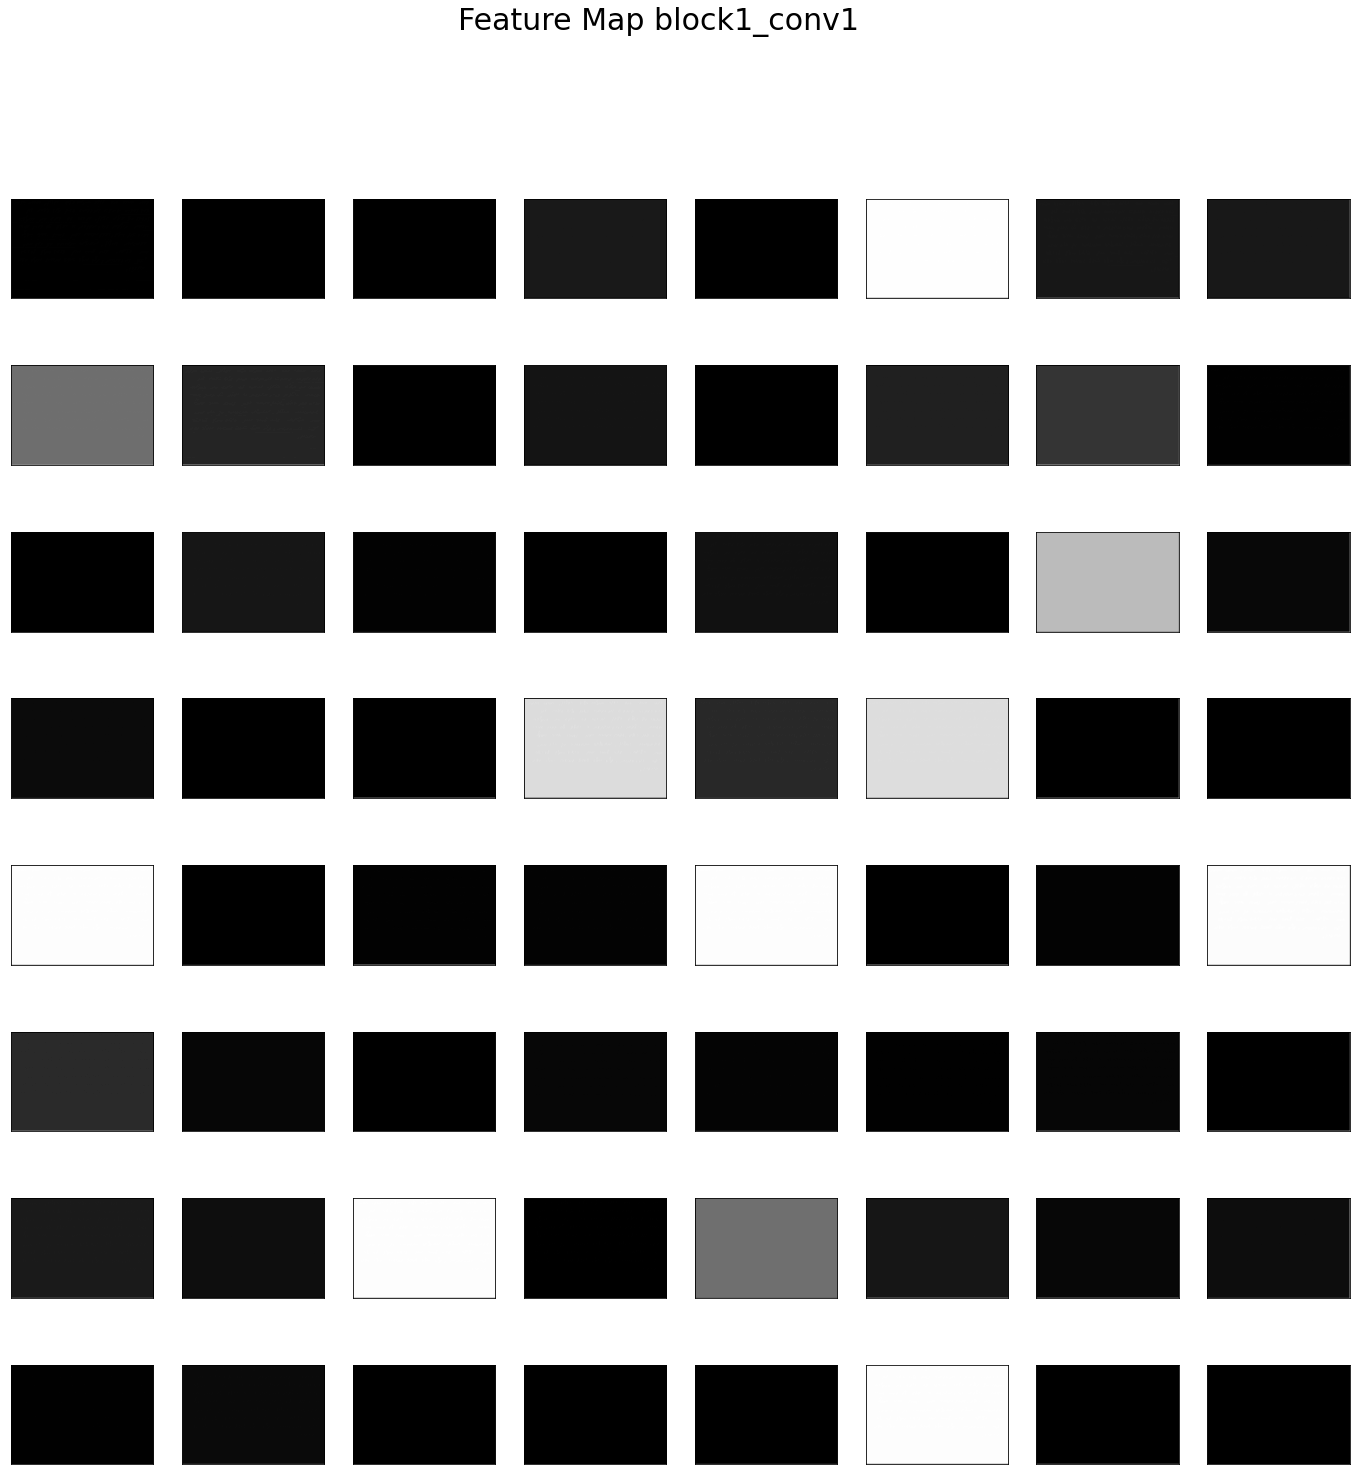

----------------------------------------------------------------------------------------------------


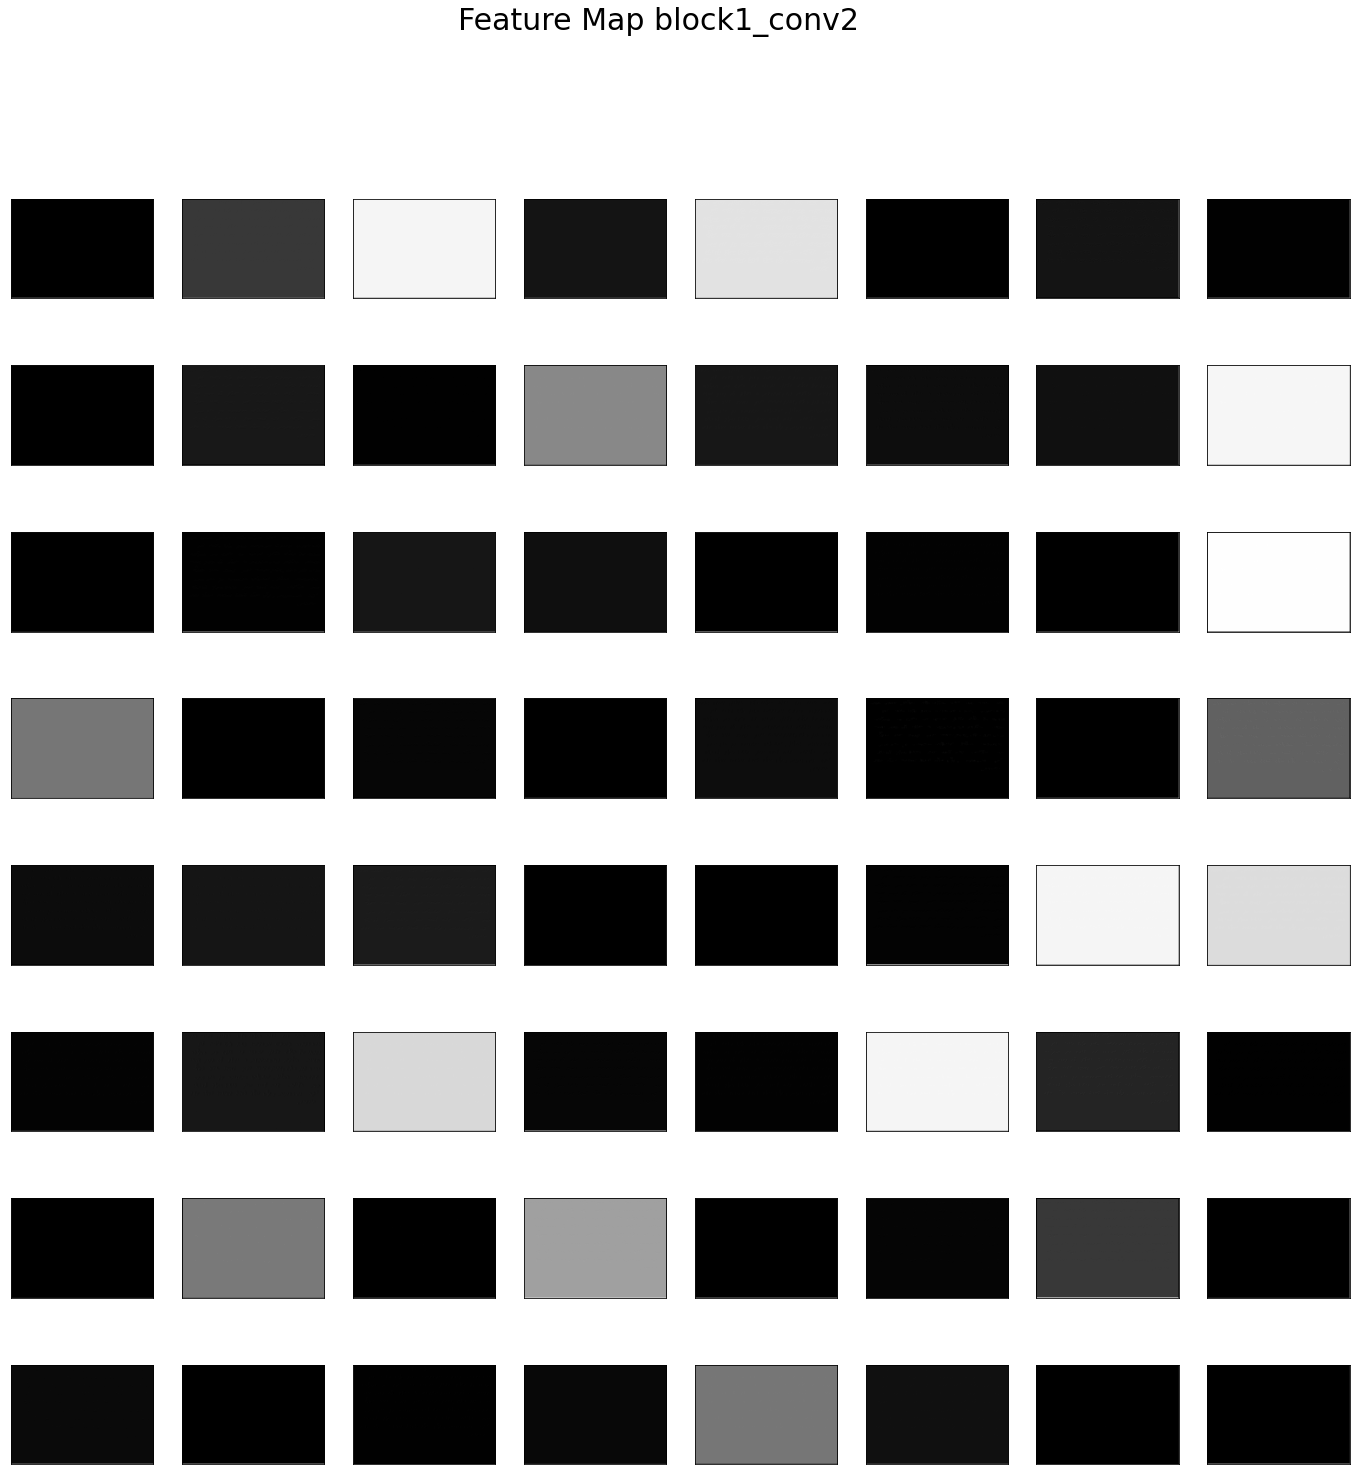

----------------------------------------------------------------------------------------------------


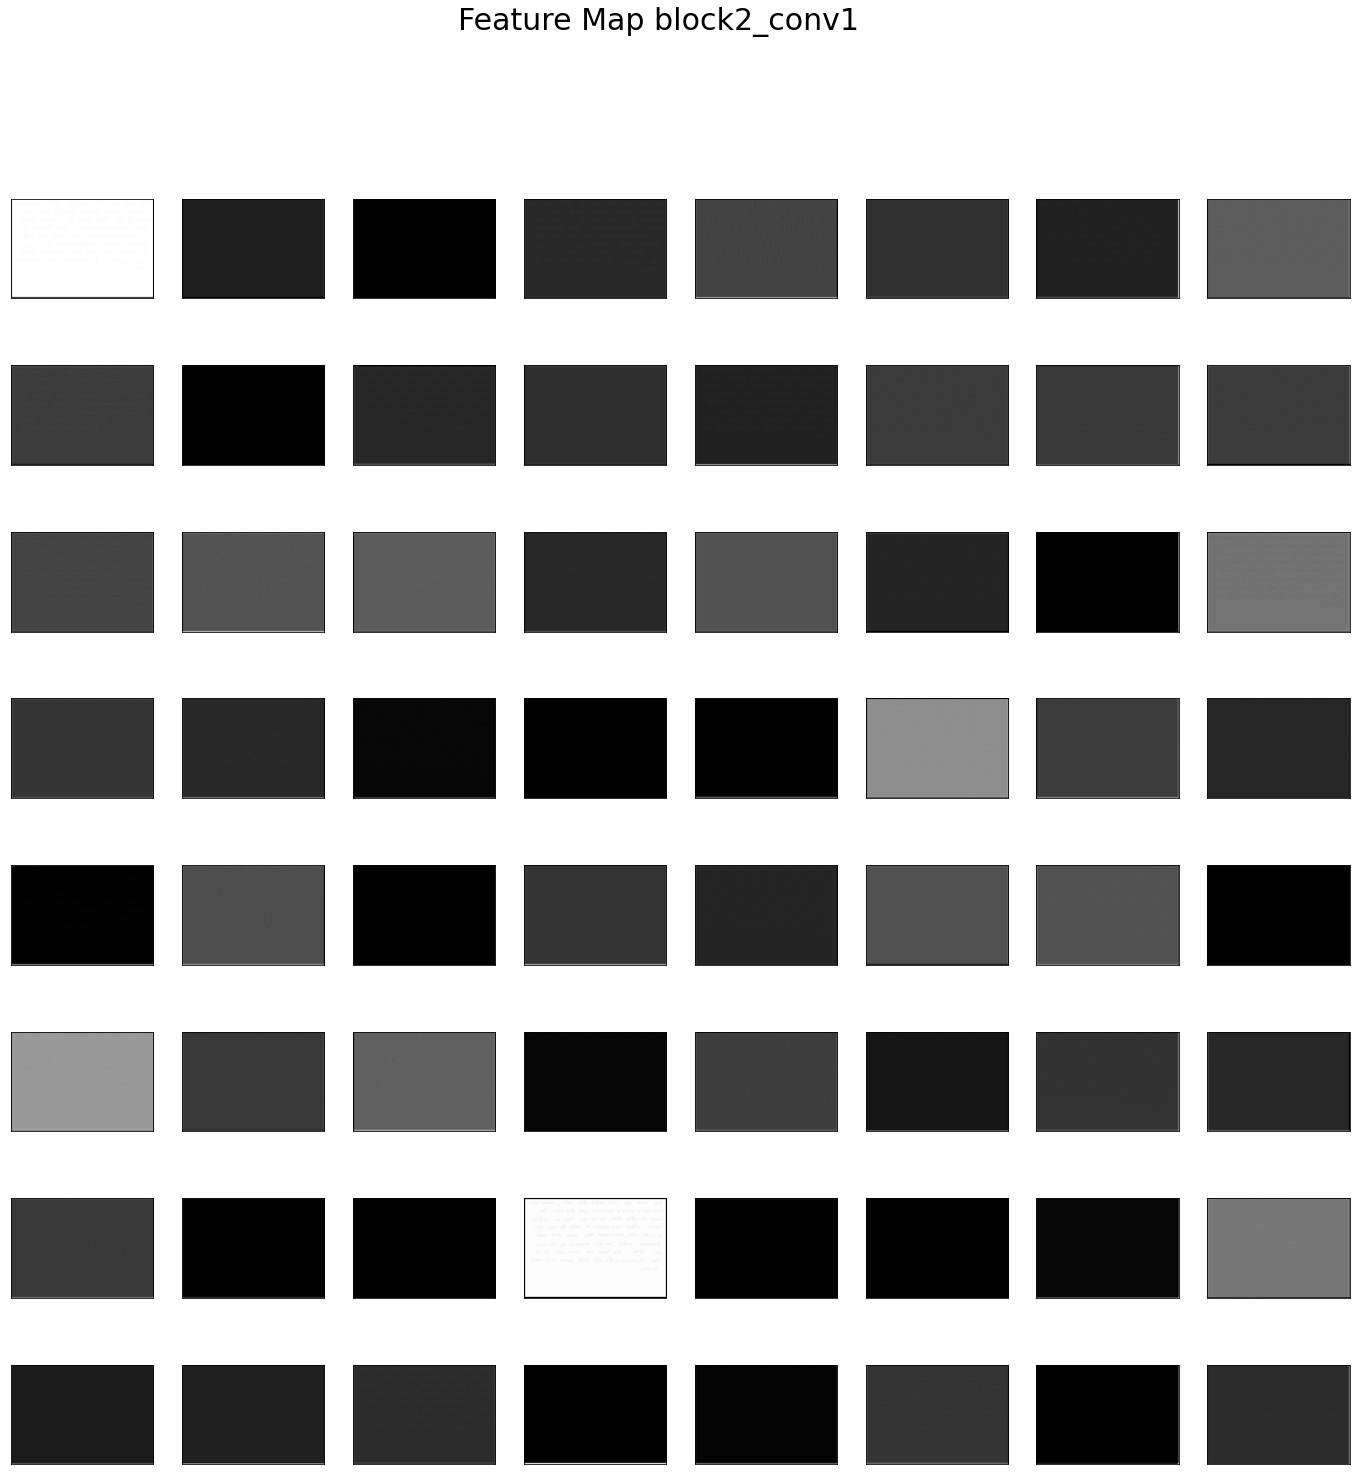

----------------------------------------------------------------------------------------------------


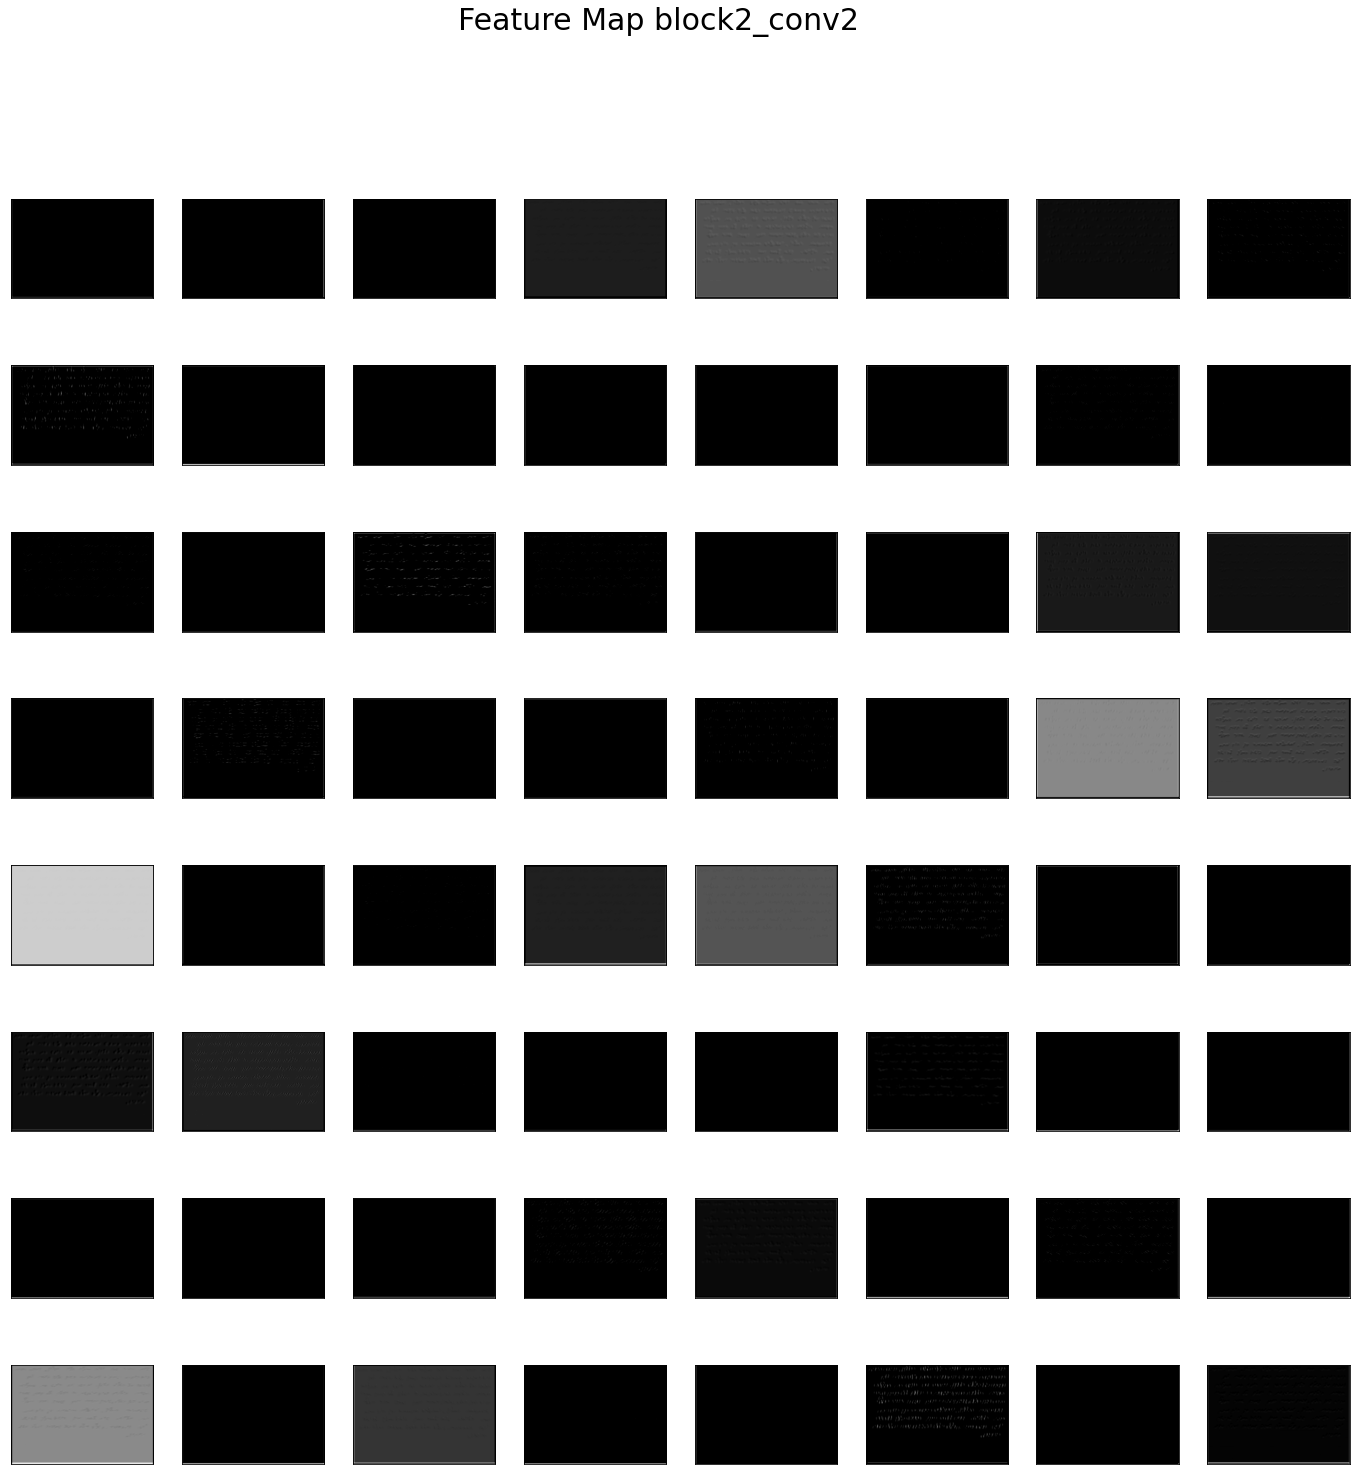

----------------------------------------------------------------------------------------------------


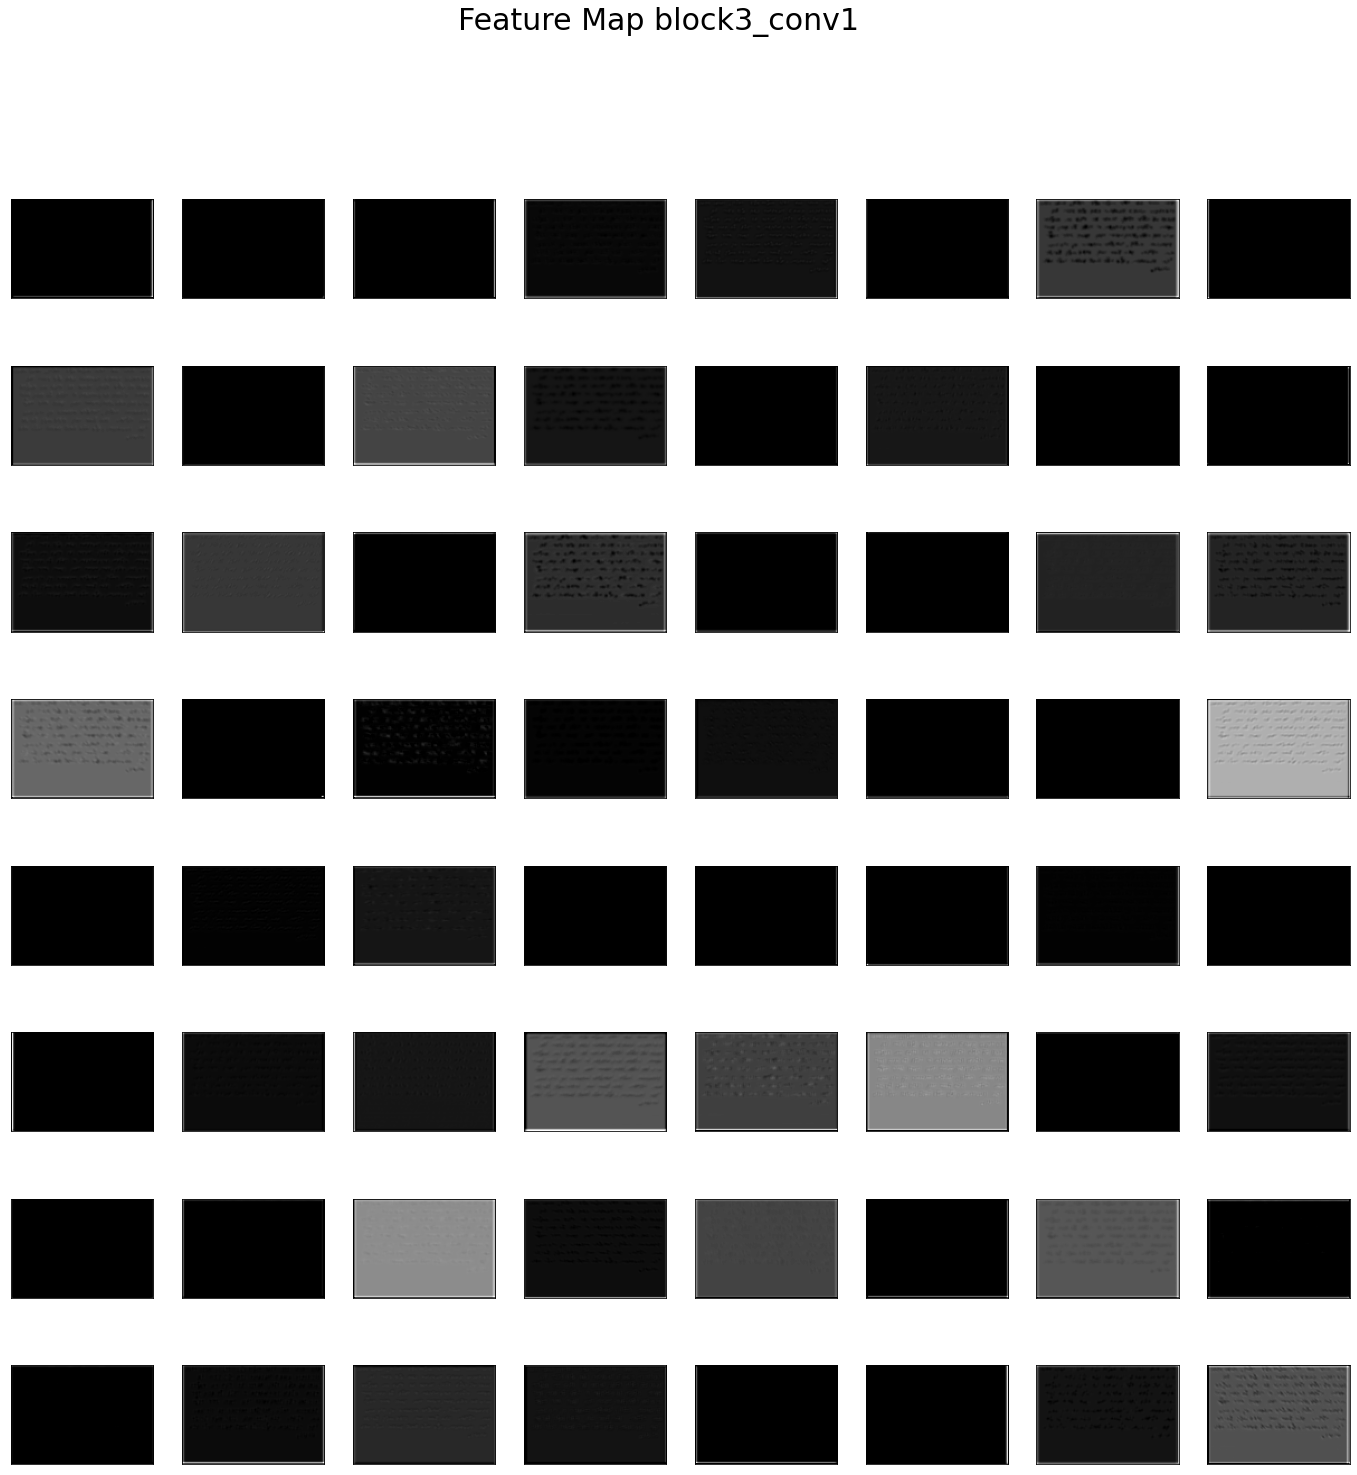

----------------------------------------------------------------------------------------------------


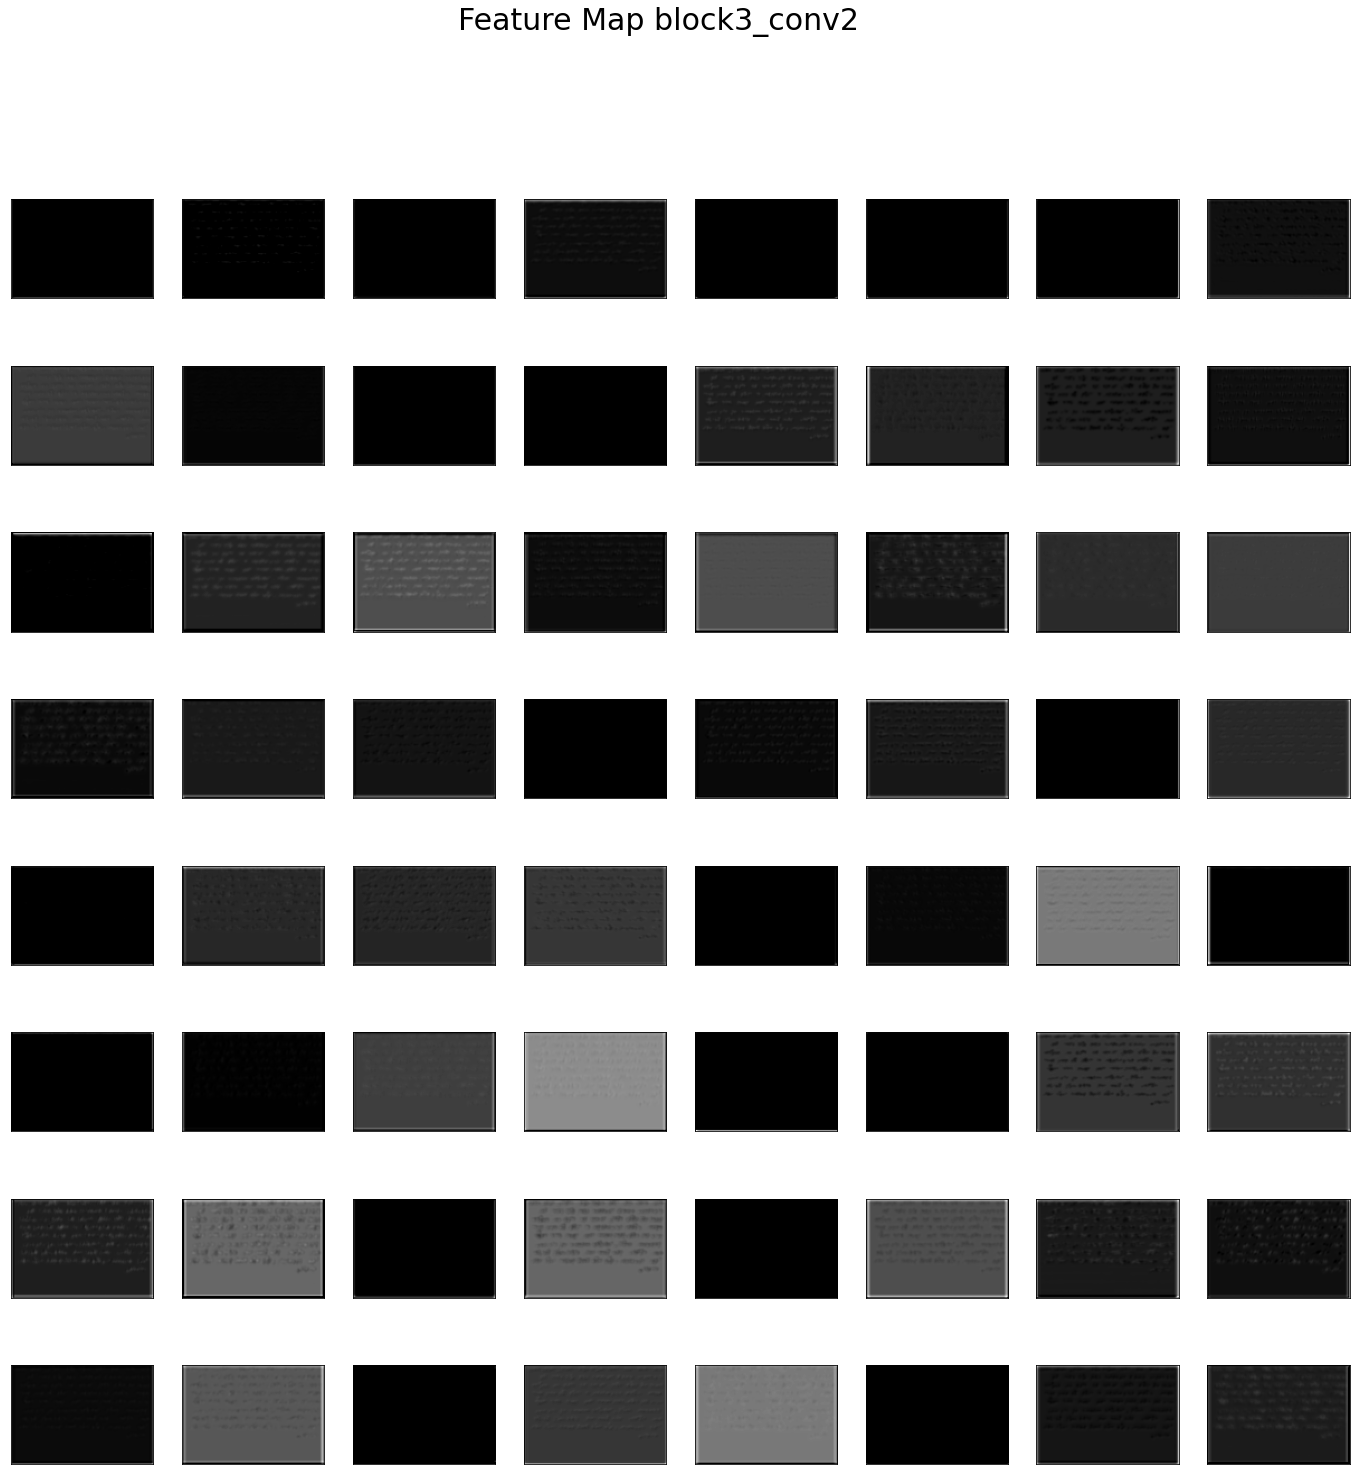

----------------------------------------------------------------------------------------------------


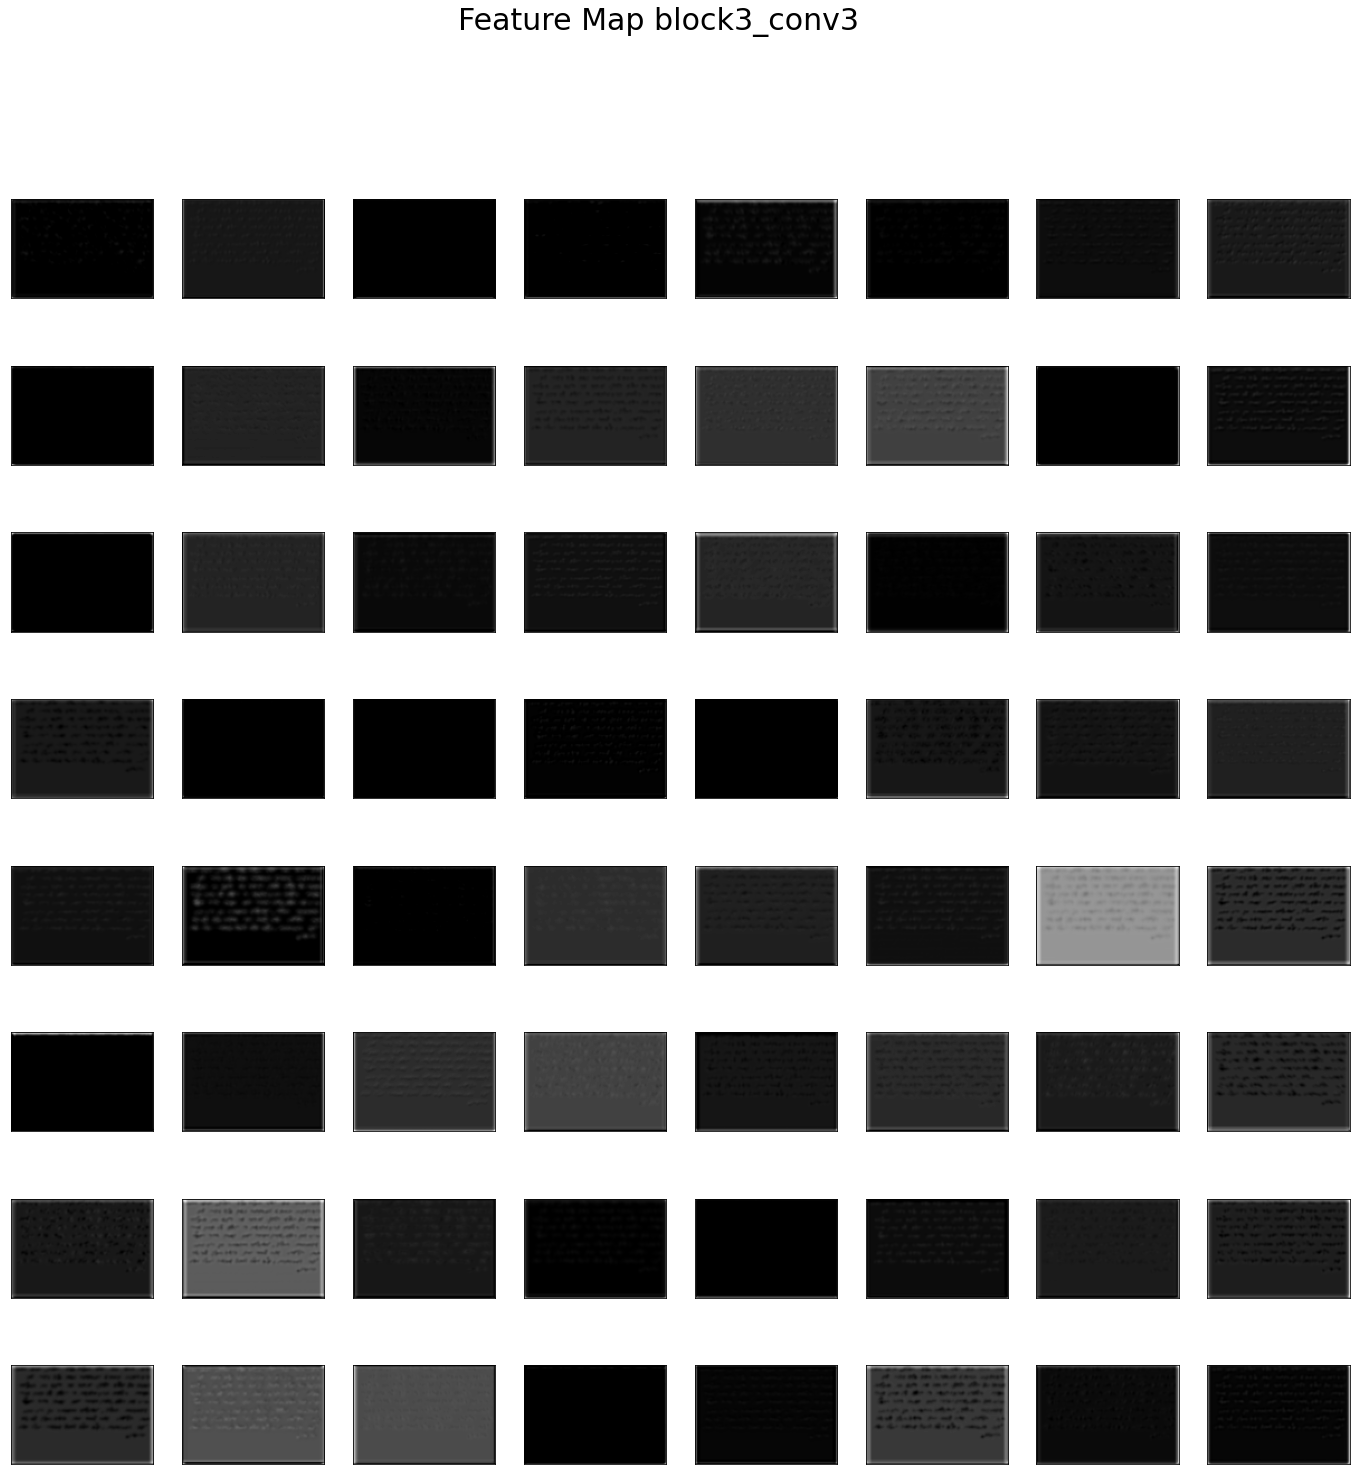

----------------------------------------------------------------------------------------------------


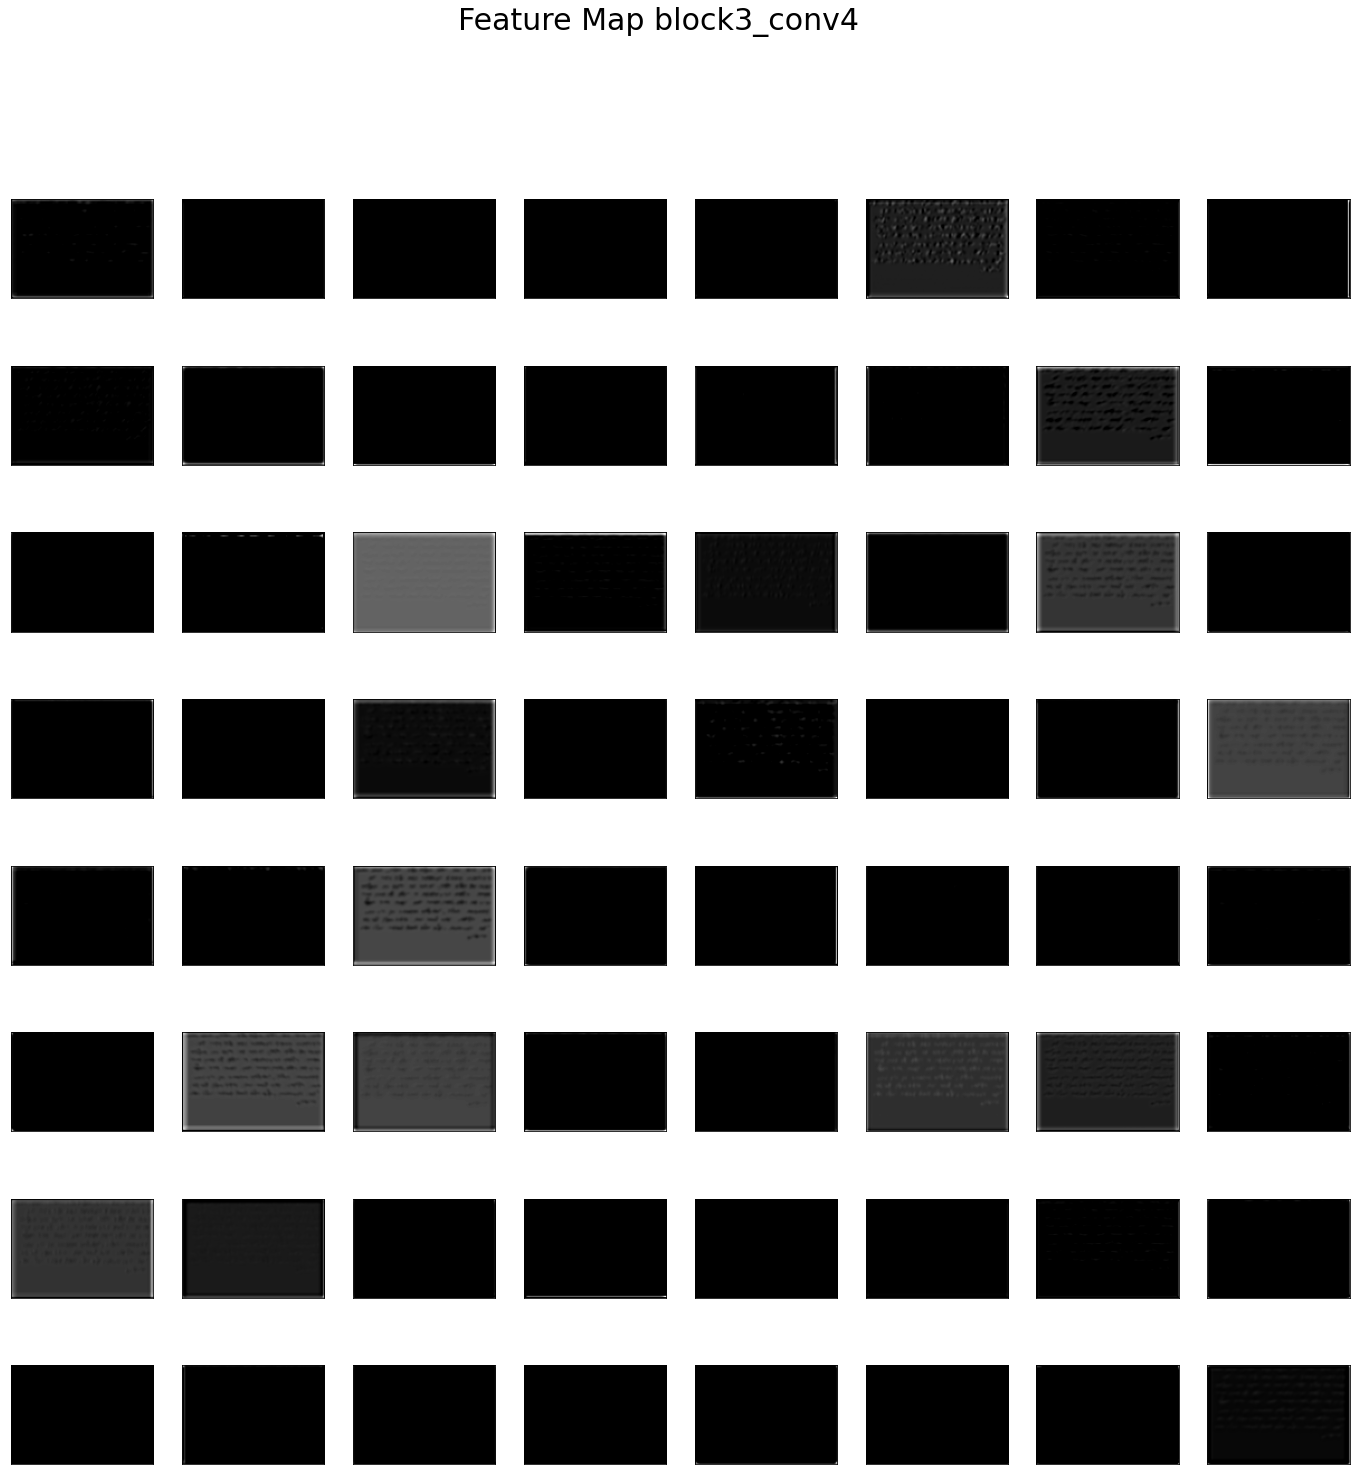

----------------------------------------------------------------------------------------------------


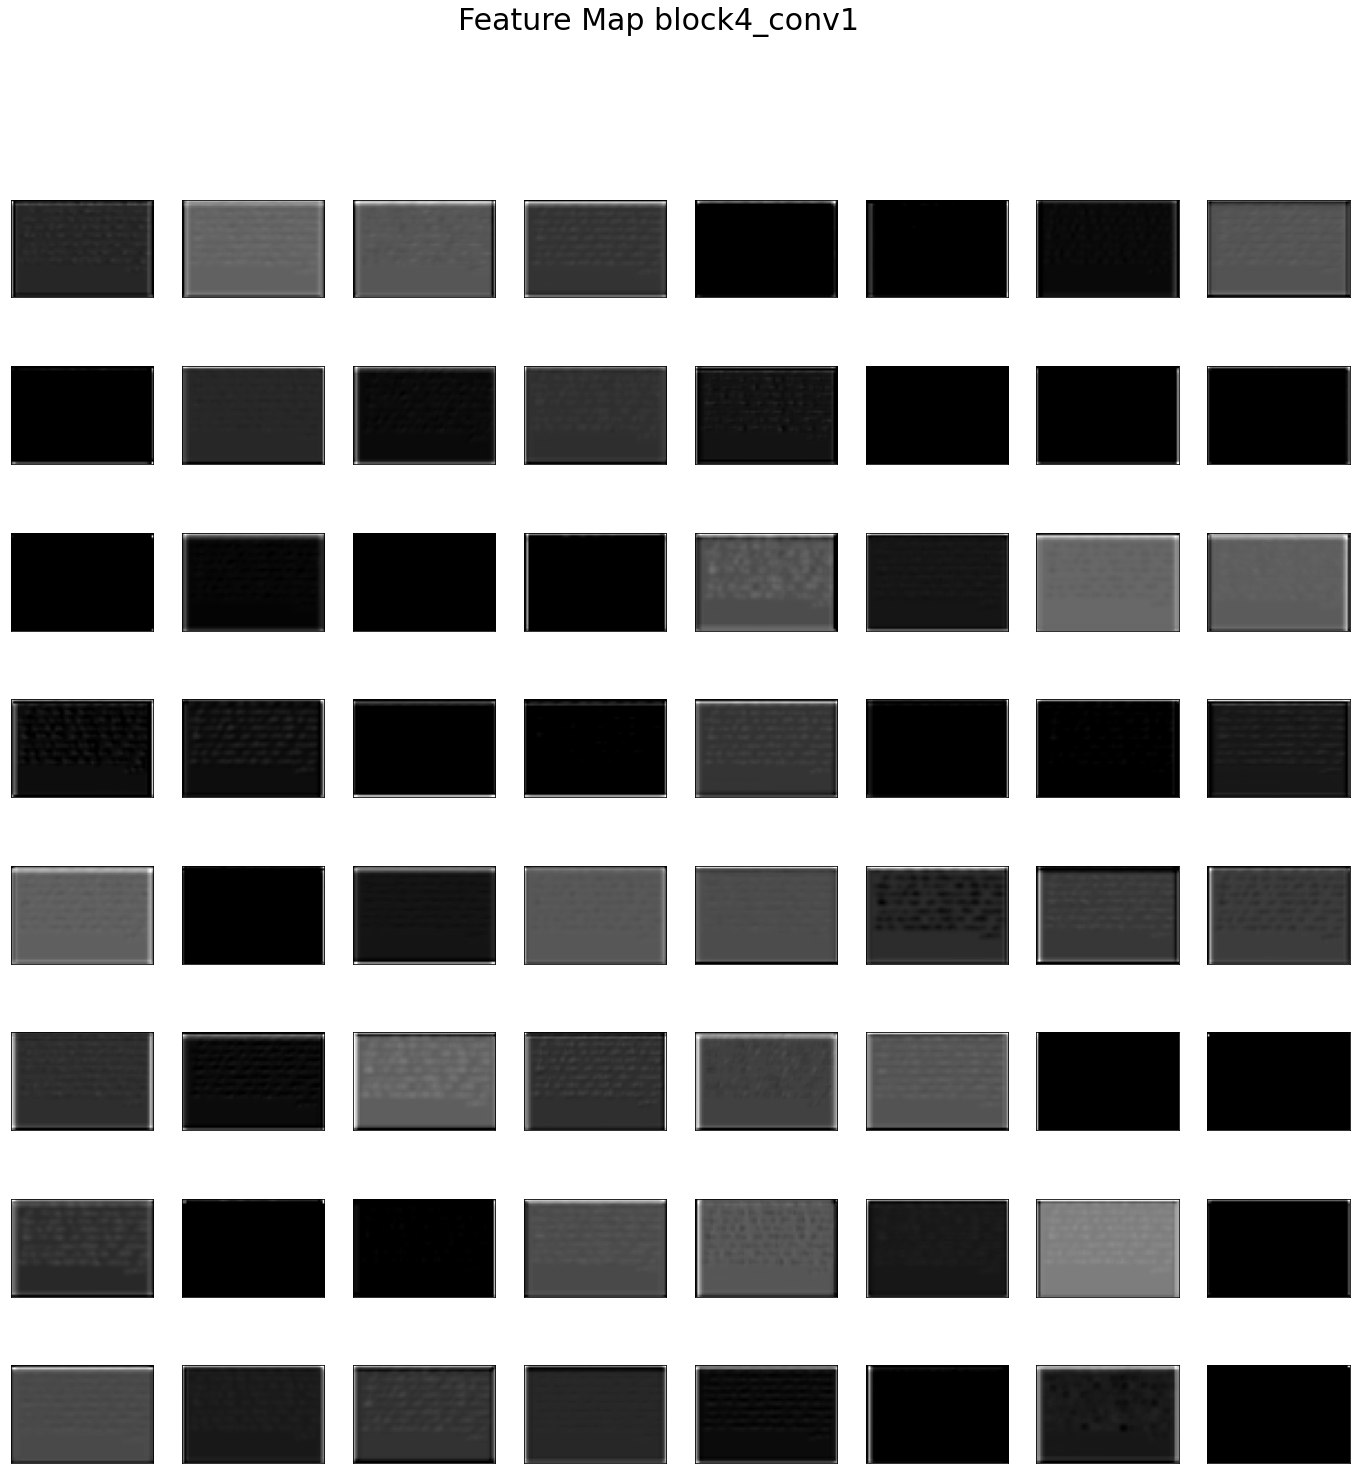

----------------------------------------------------------------------------------------------------


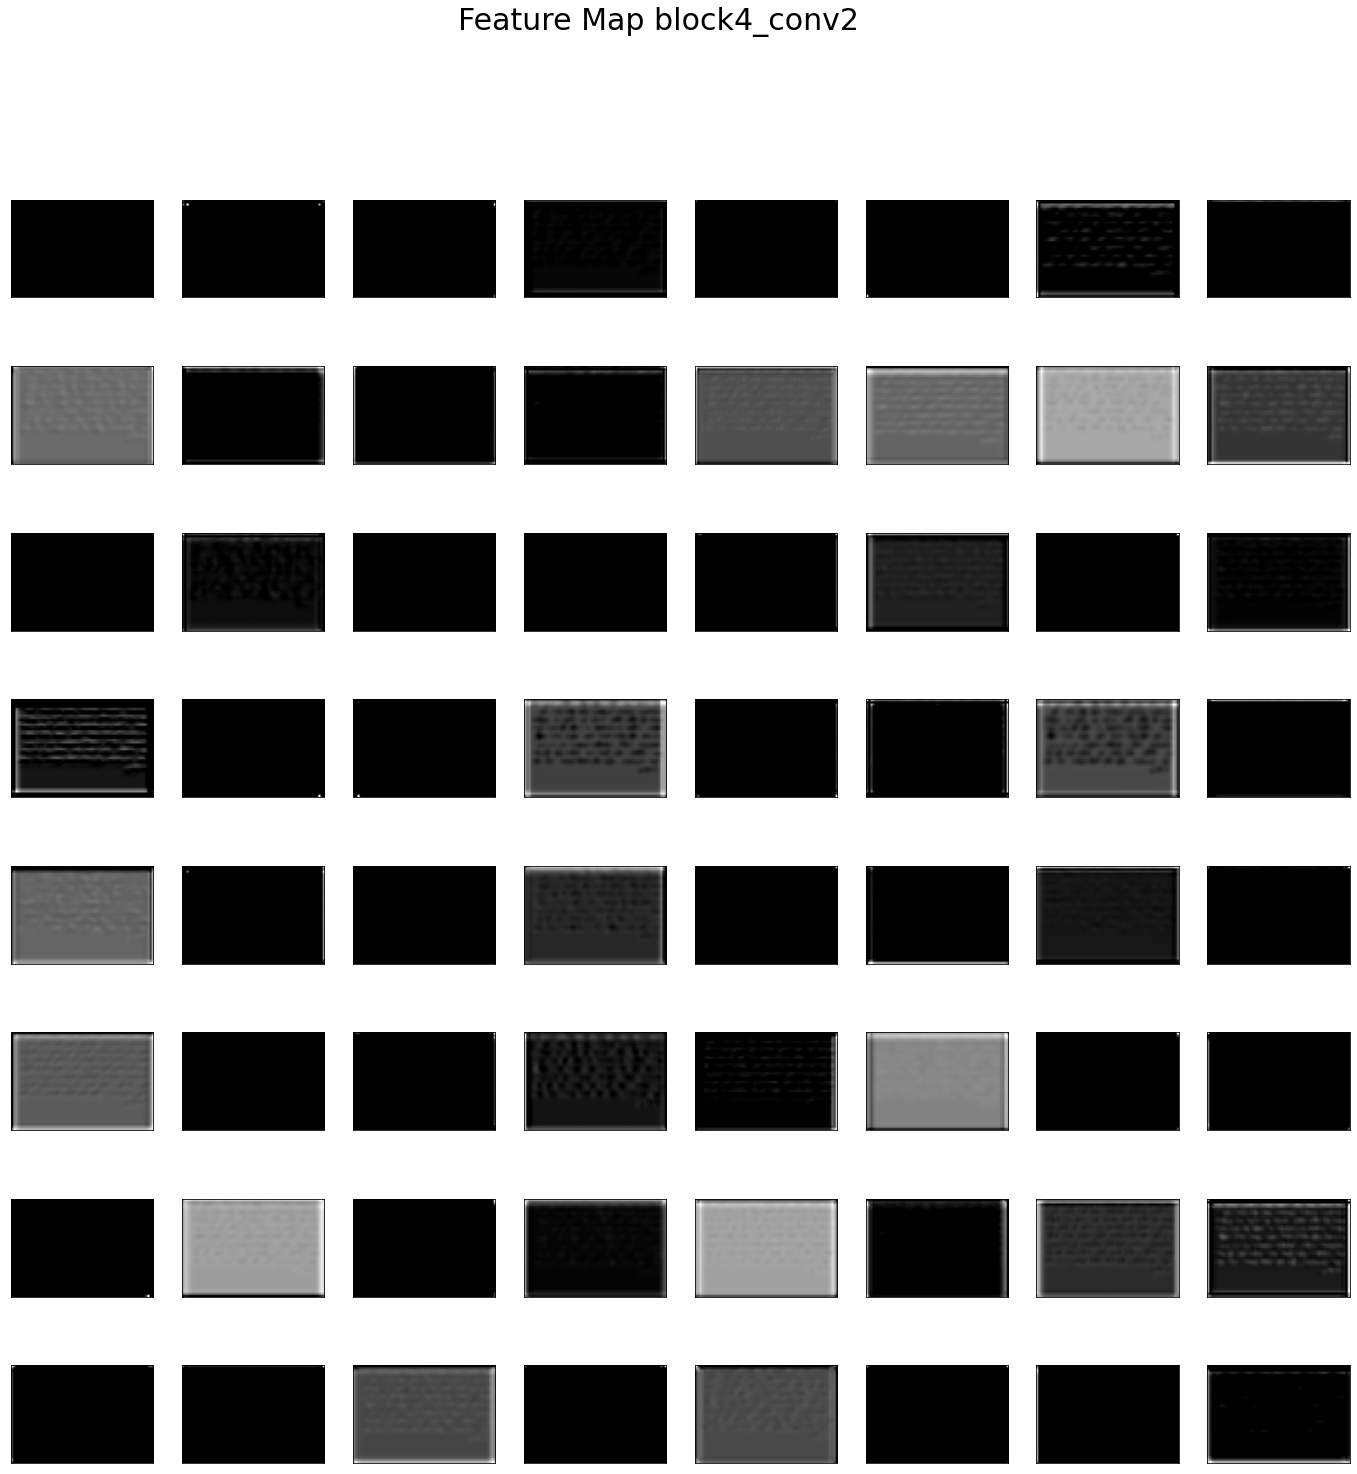

----------------------------------------------------------------------------------------------------


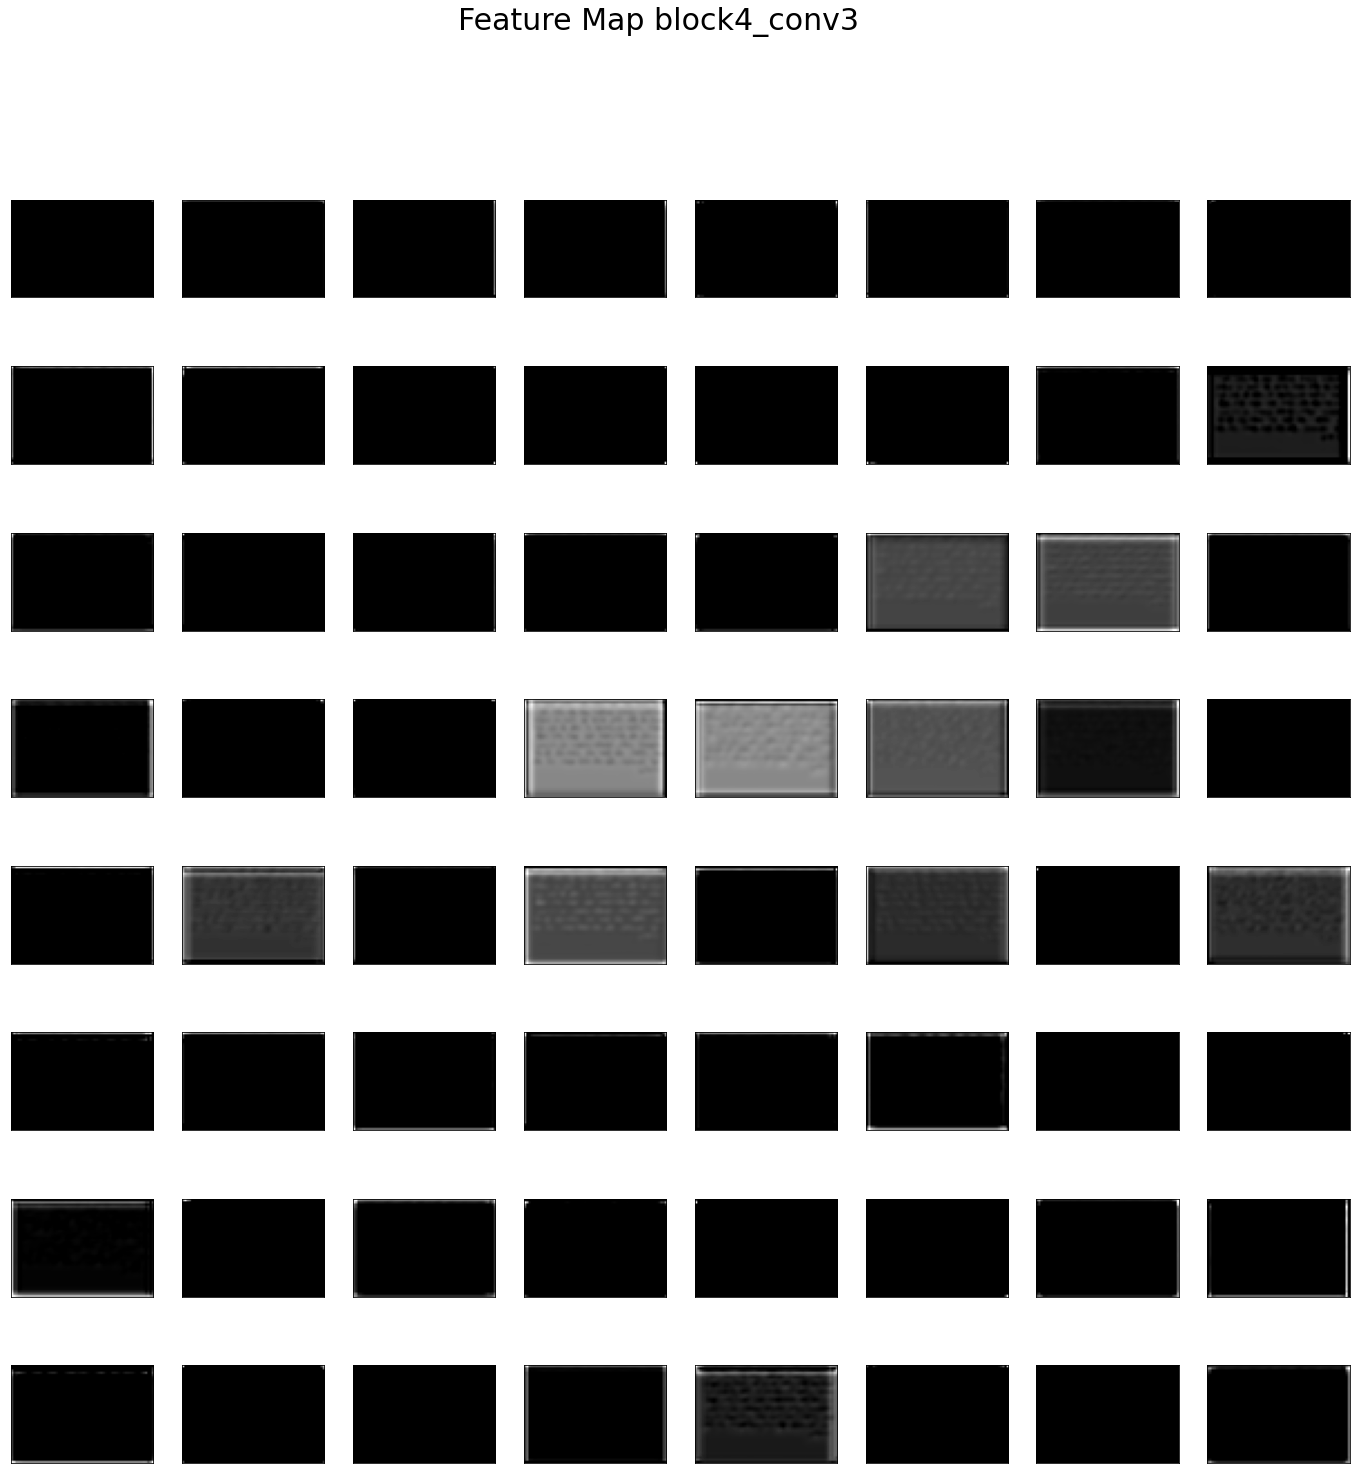

----------------------------------------------------------------------------------------------------


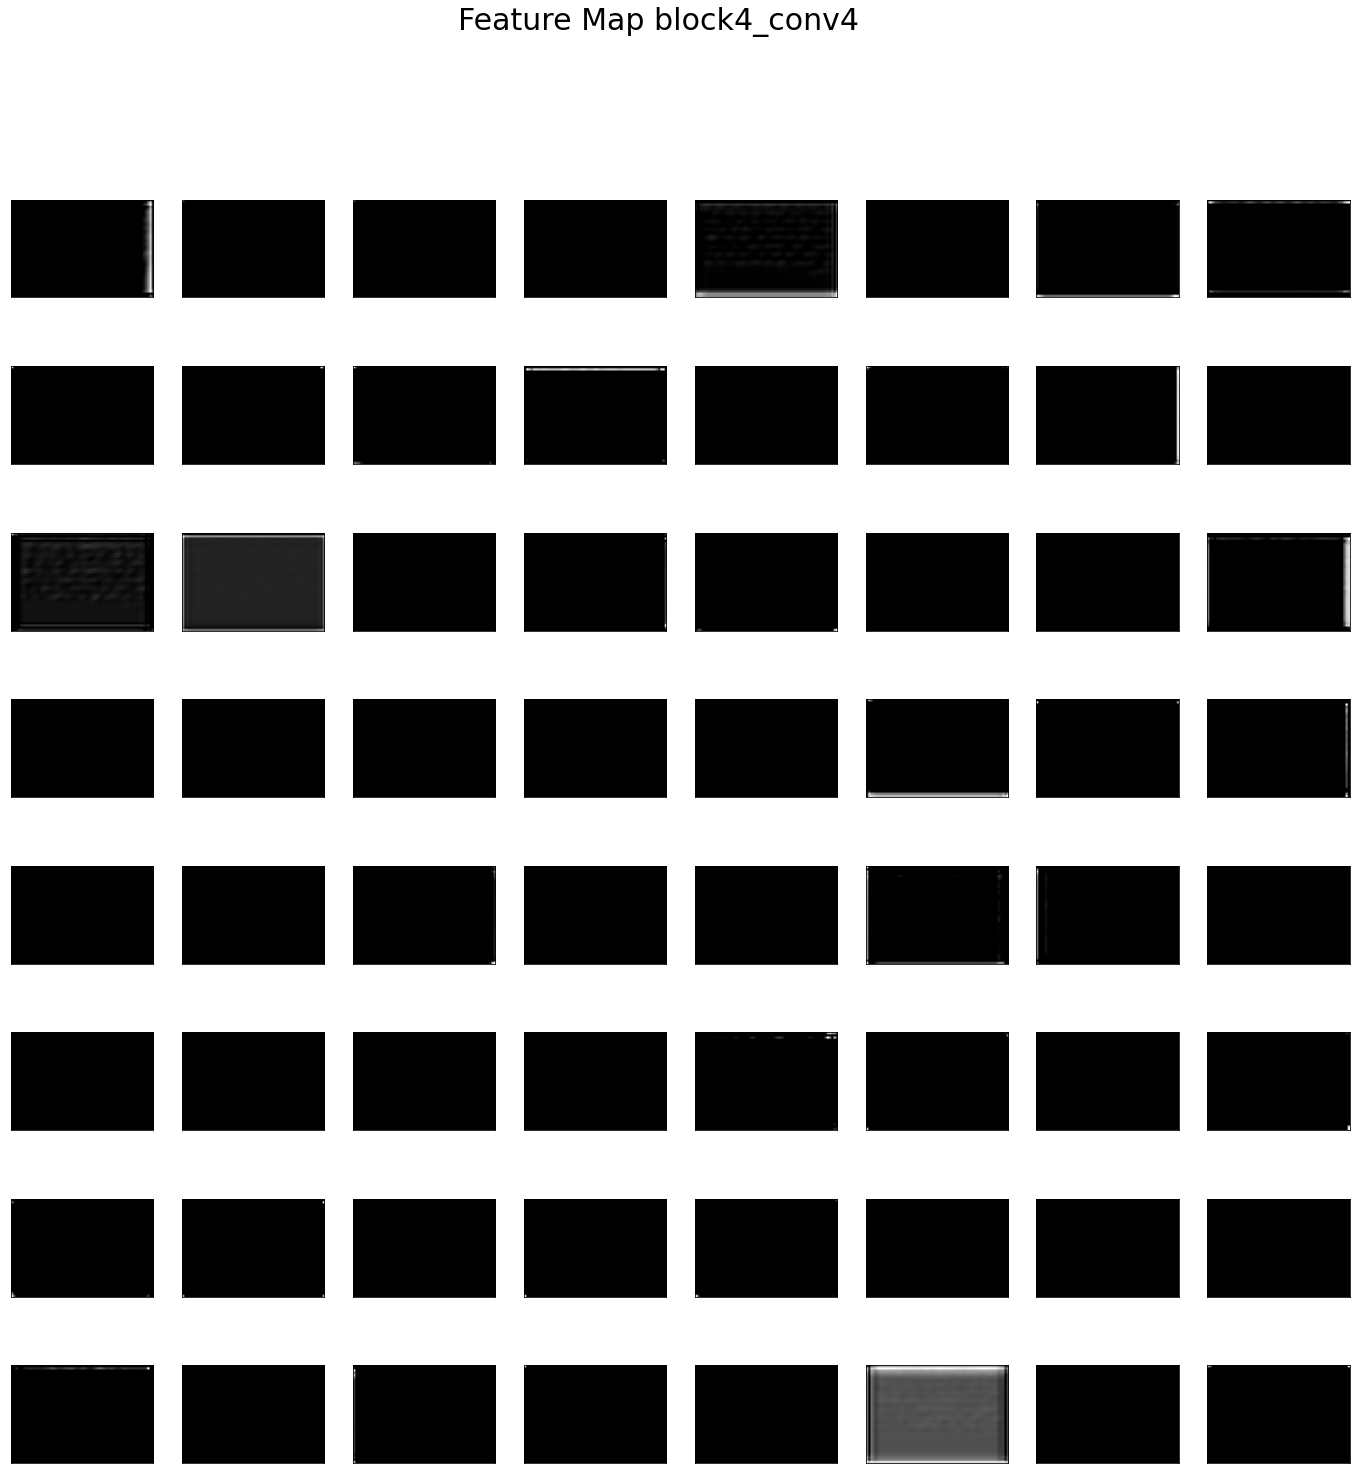

----------------------------------------------------------------------------------------------------


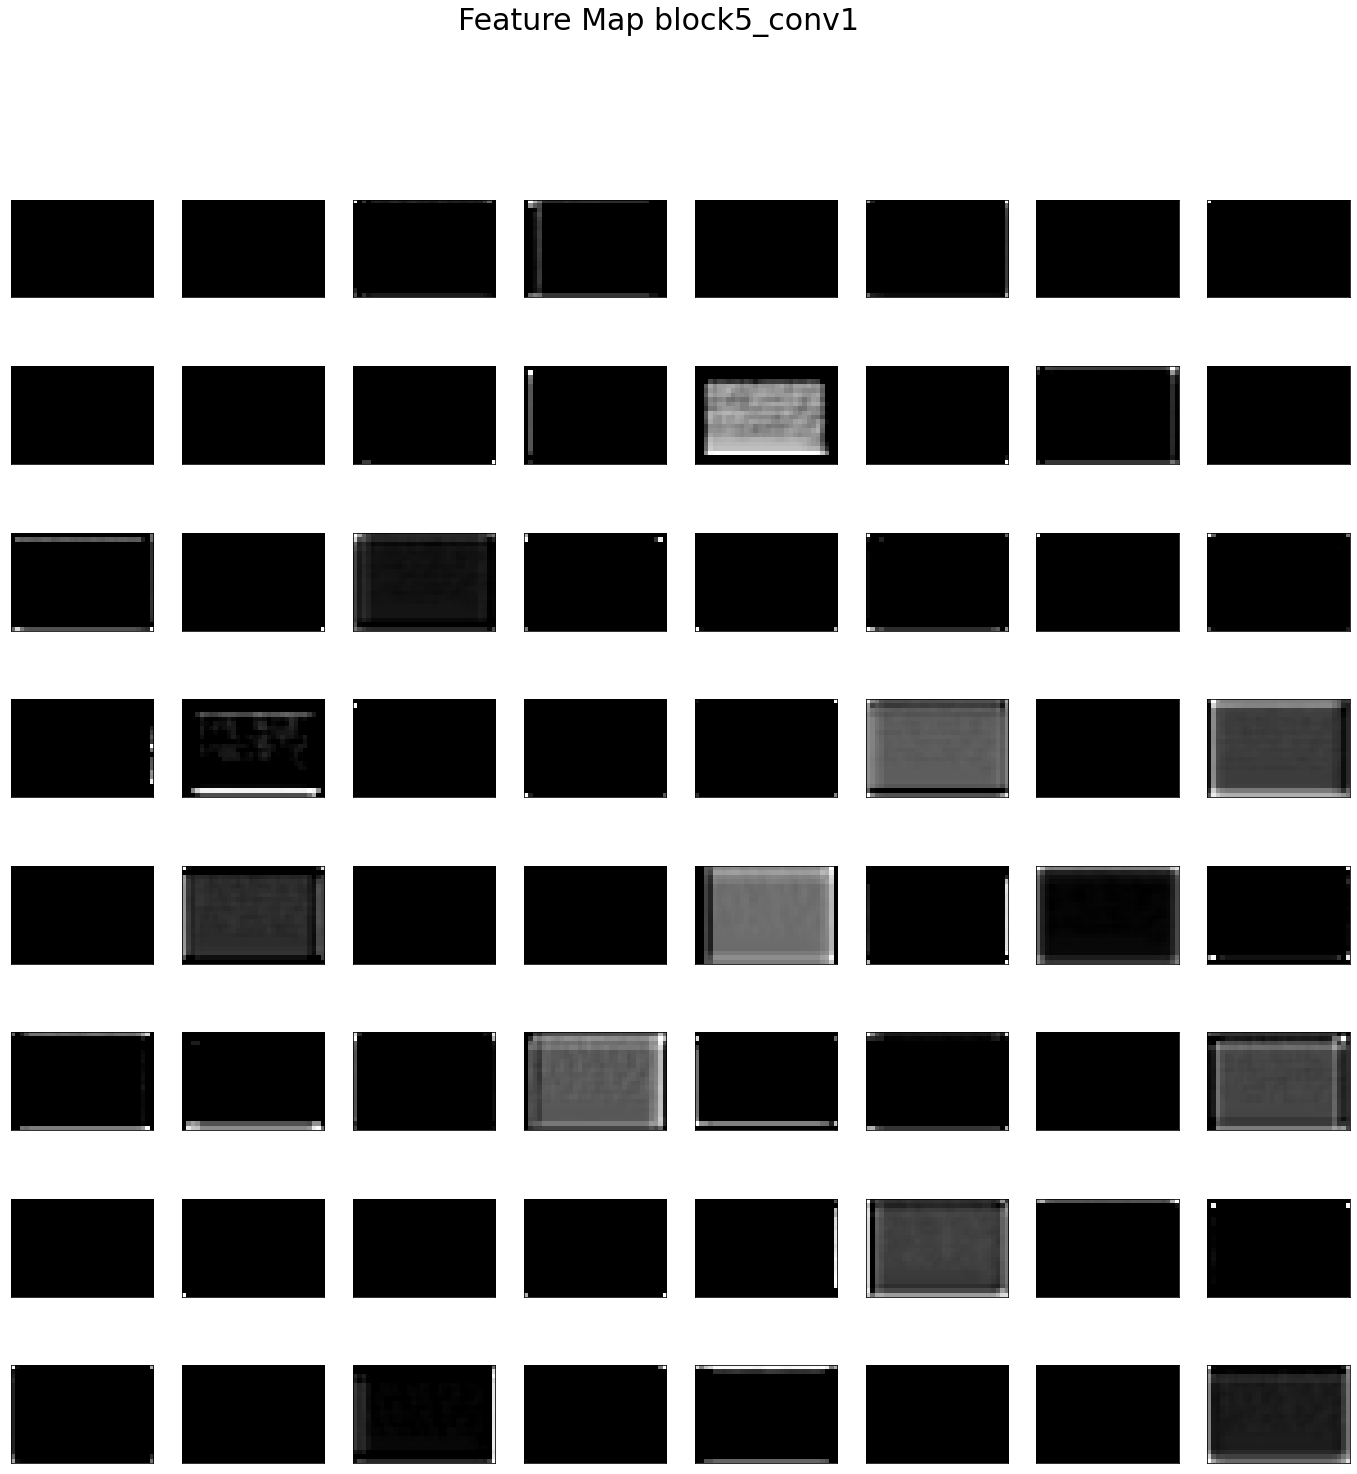

----------------------------------------------------------------------------------------------------


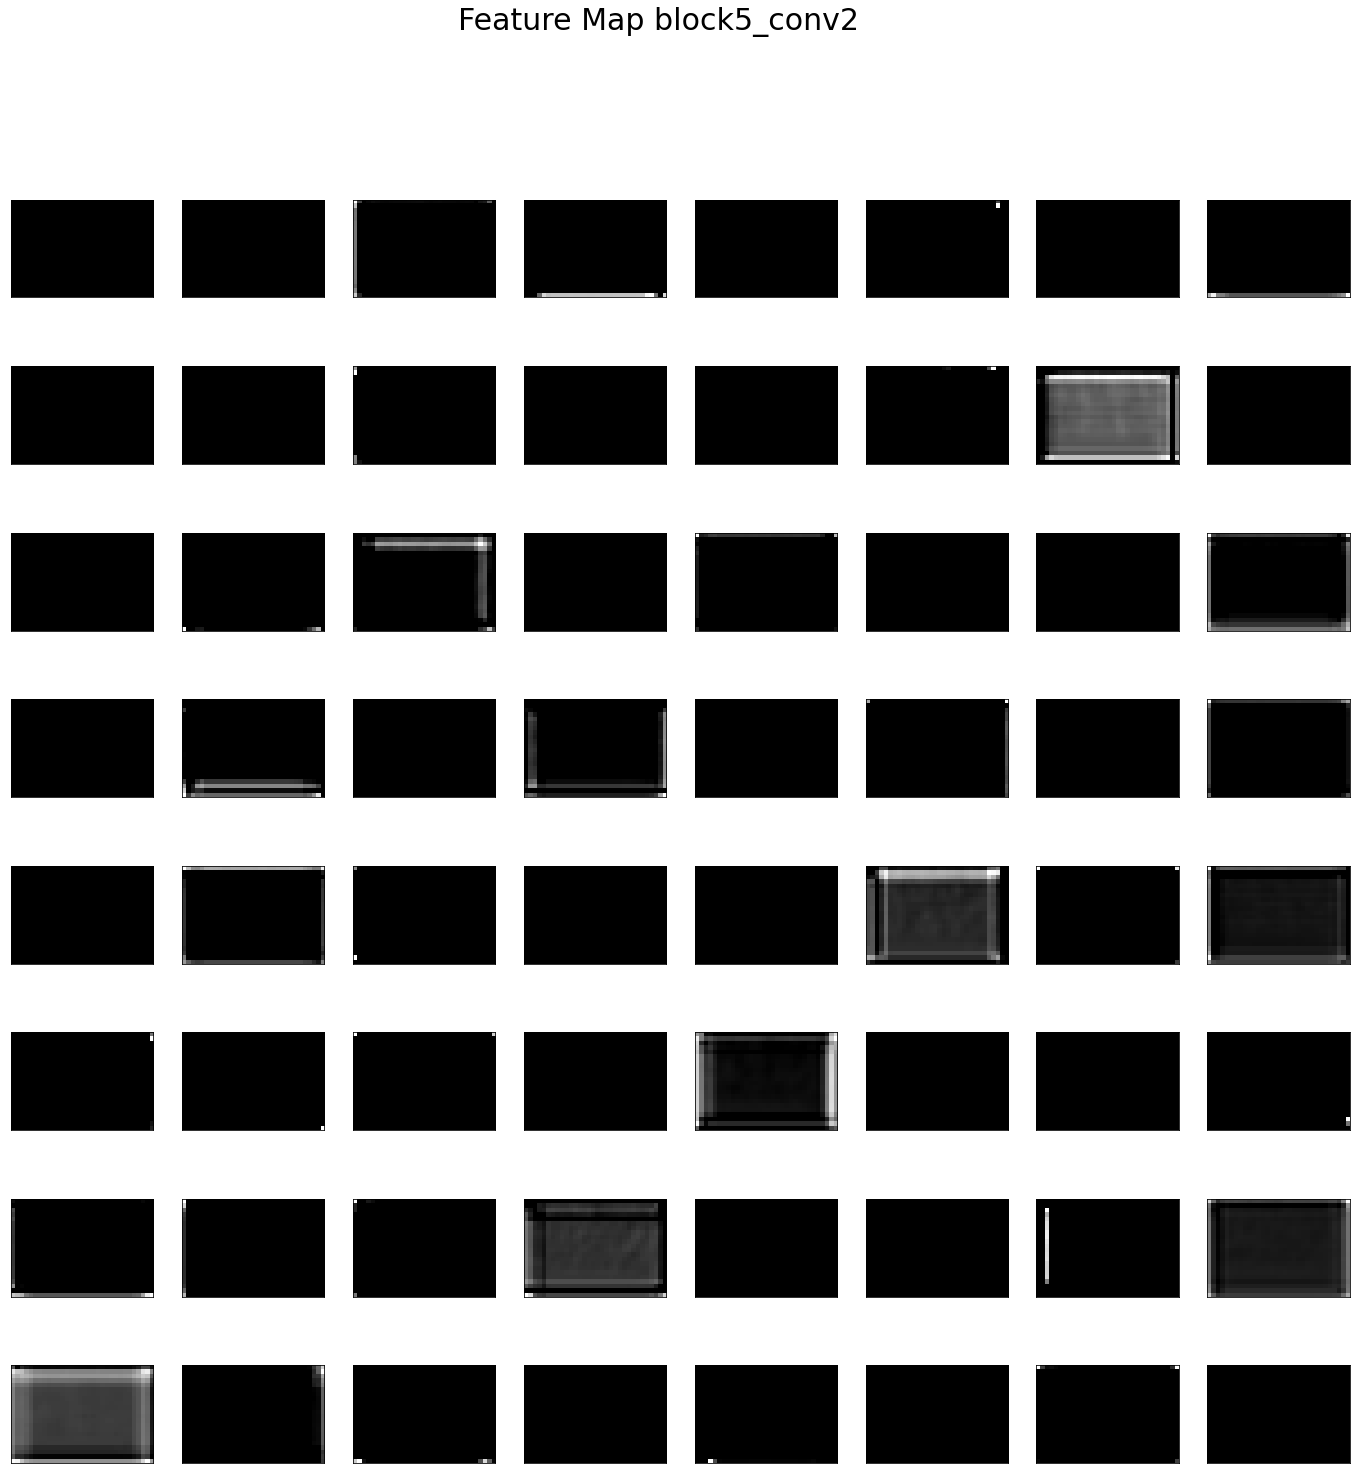

----------------------------------------------------------------------------------------------------


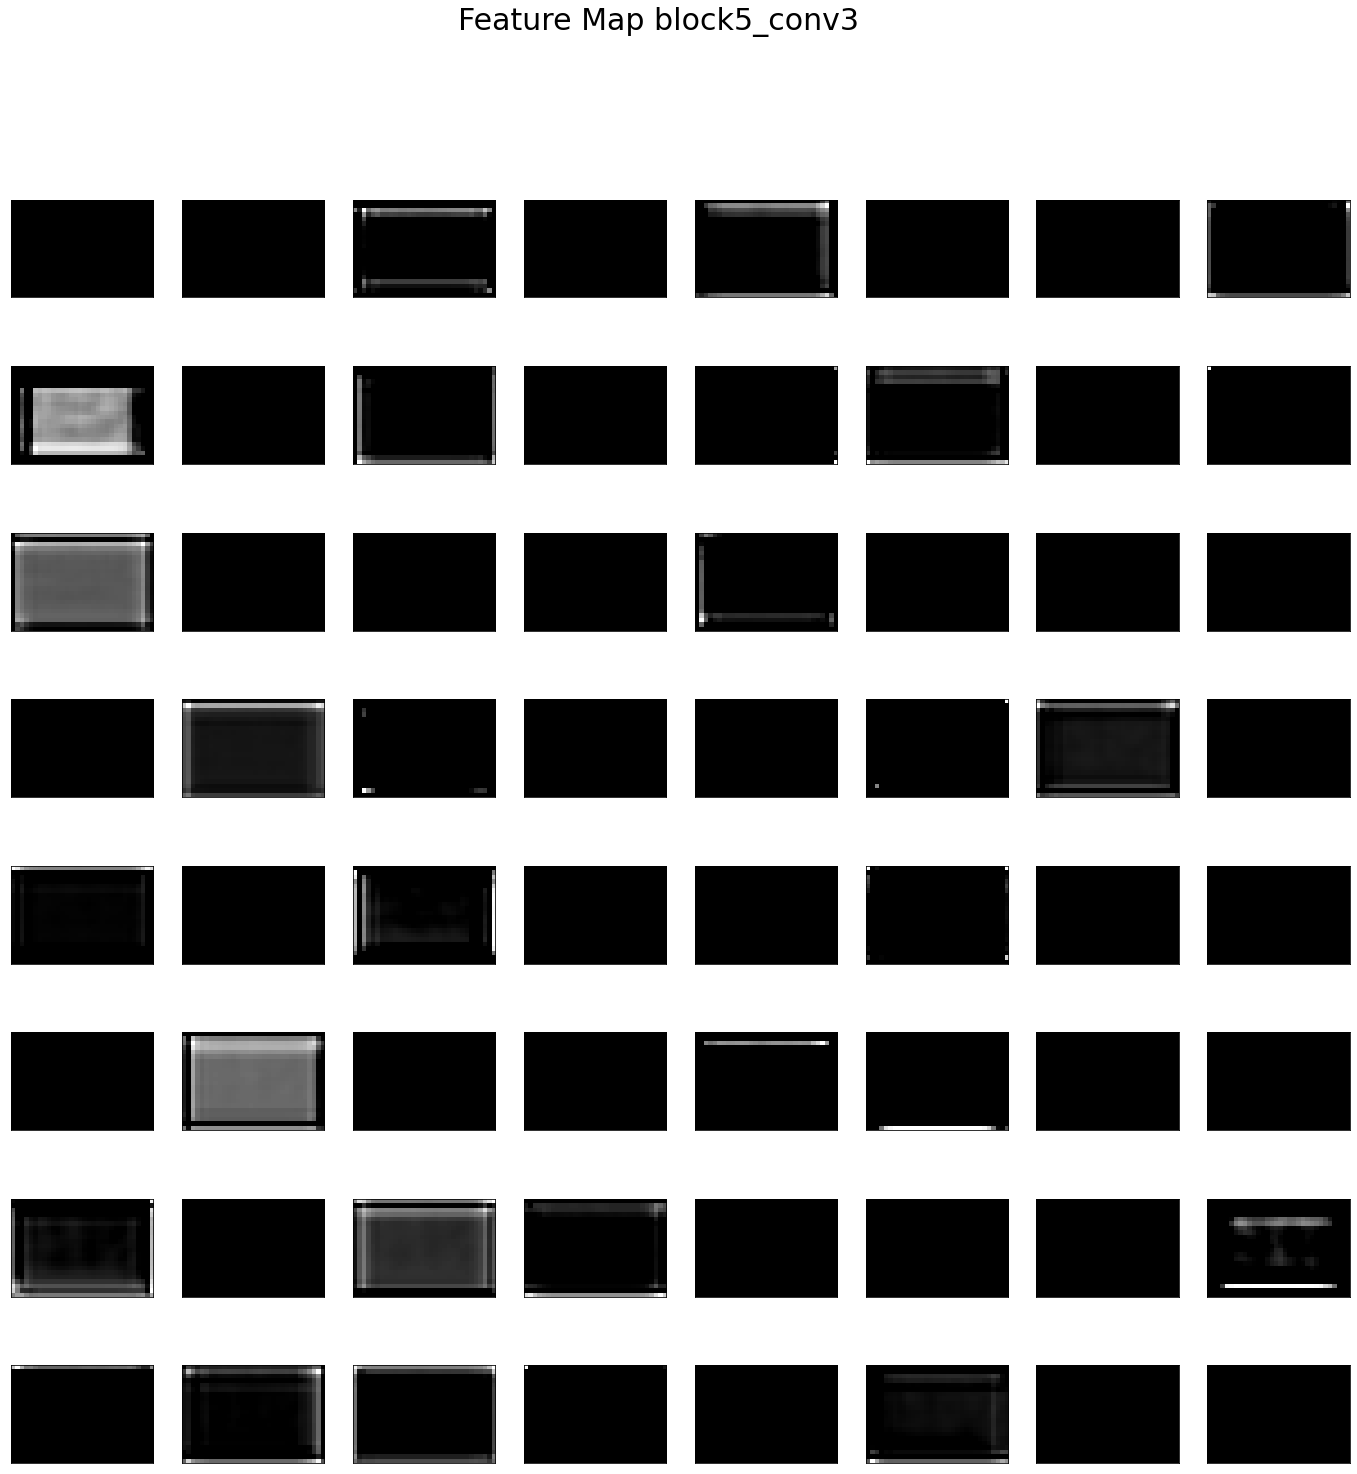

----------------------------------------------------------------------------------------------------


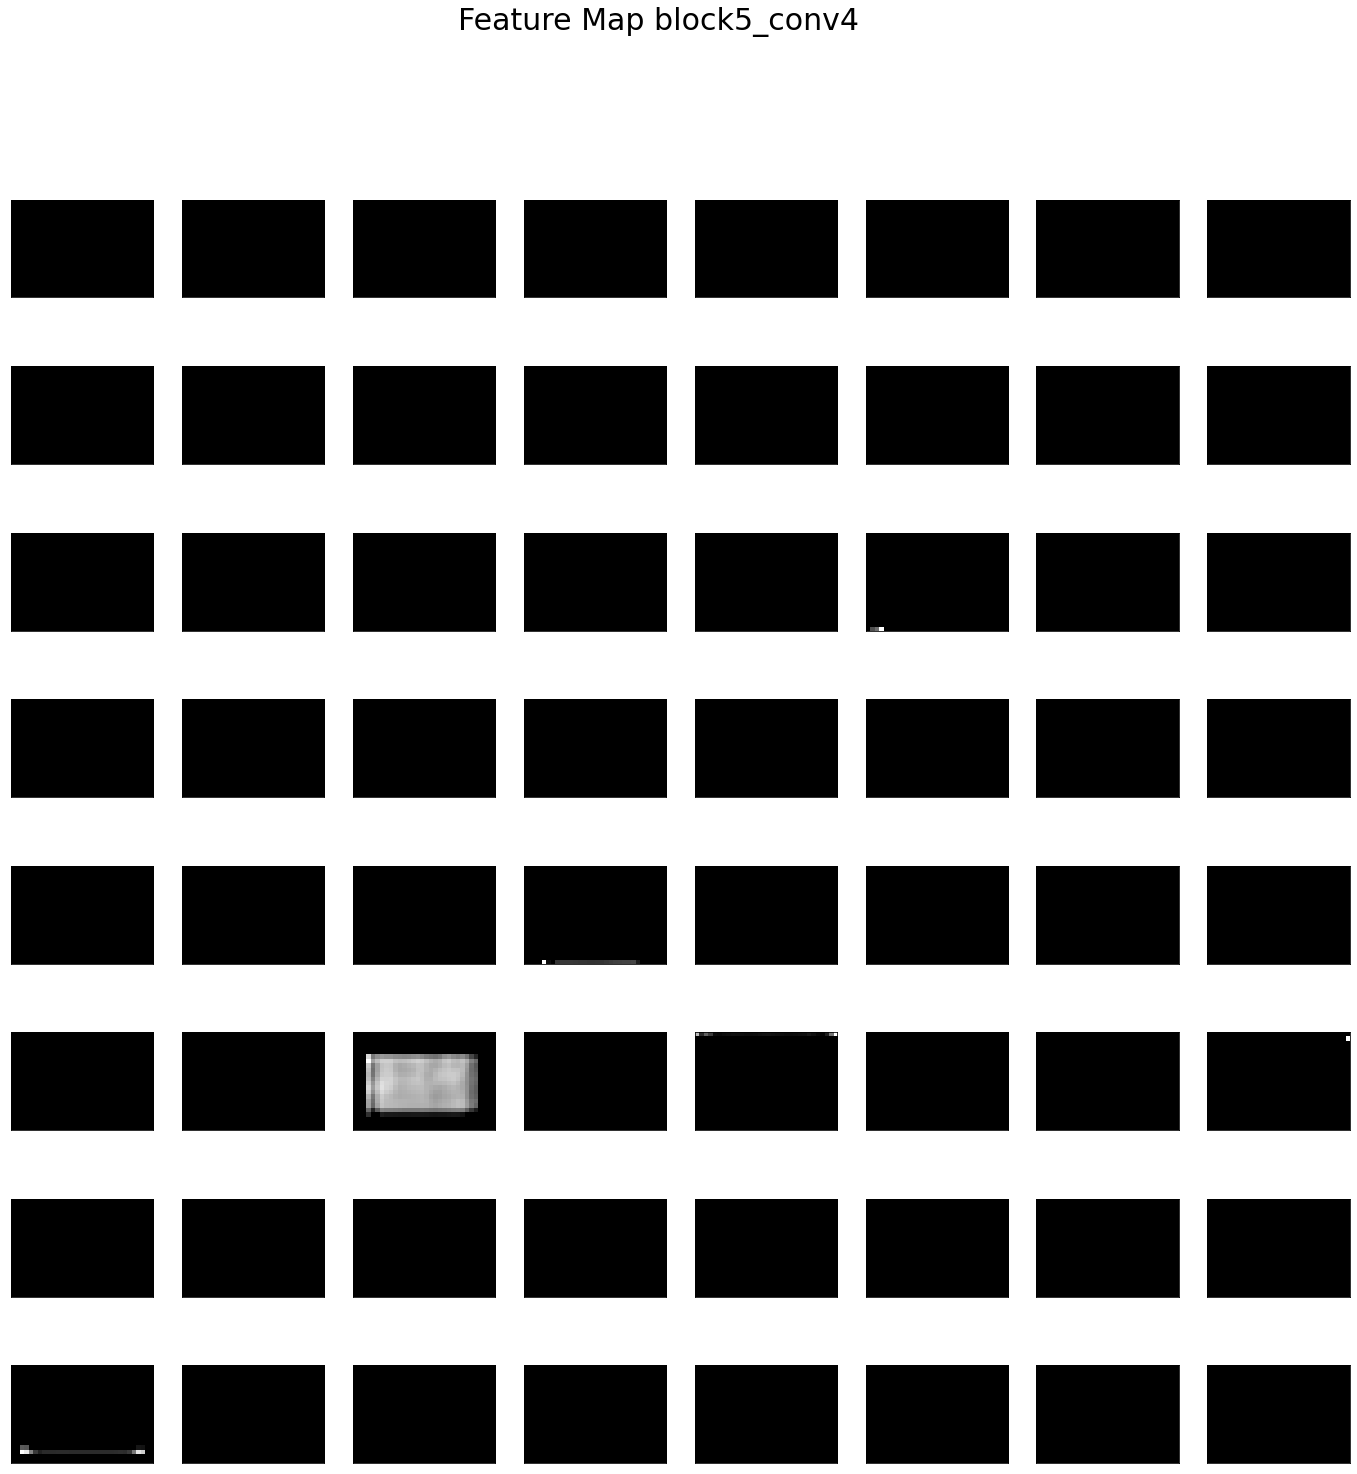

----------------------------------------------------------------------------------------------------


In [12]:
# delete old results
figures_folder_path: str = '/content/content_feature_maps'
if os.path.exists(figures_folder_path):
    shutil.rmtree(figures_folder_path)
os.makedirs(figures_folder_path)

# plot the feature maps
for i in range(0, len(outputs)):
  # we will only show 64 features to get the feeling of the layer
  feature_maps_plot(8, 8, content_feature_maps[i], f"Feature Map {outputs[i]}",
                    figures_folder_path)
  print('-' * 100)

Plot for style:

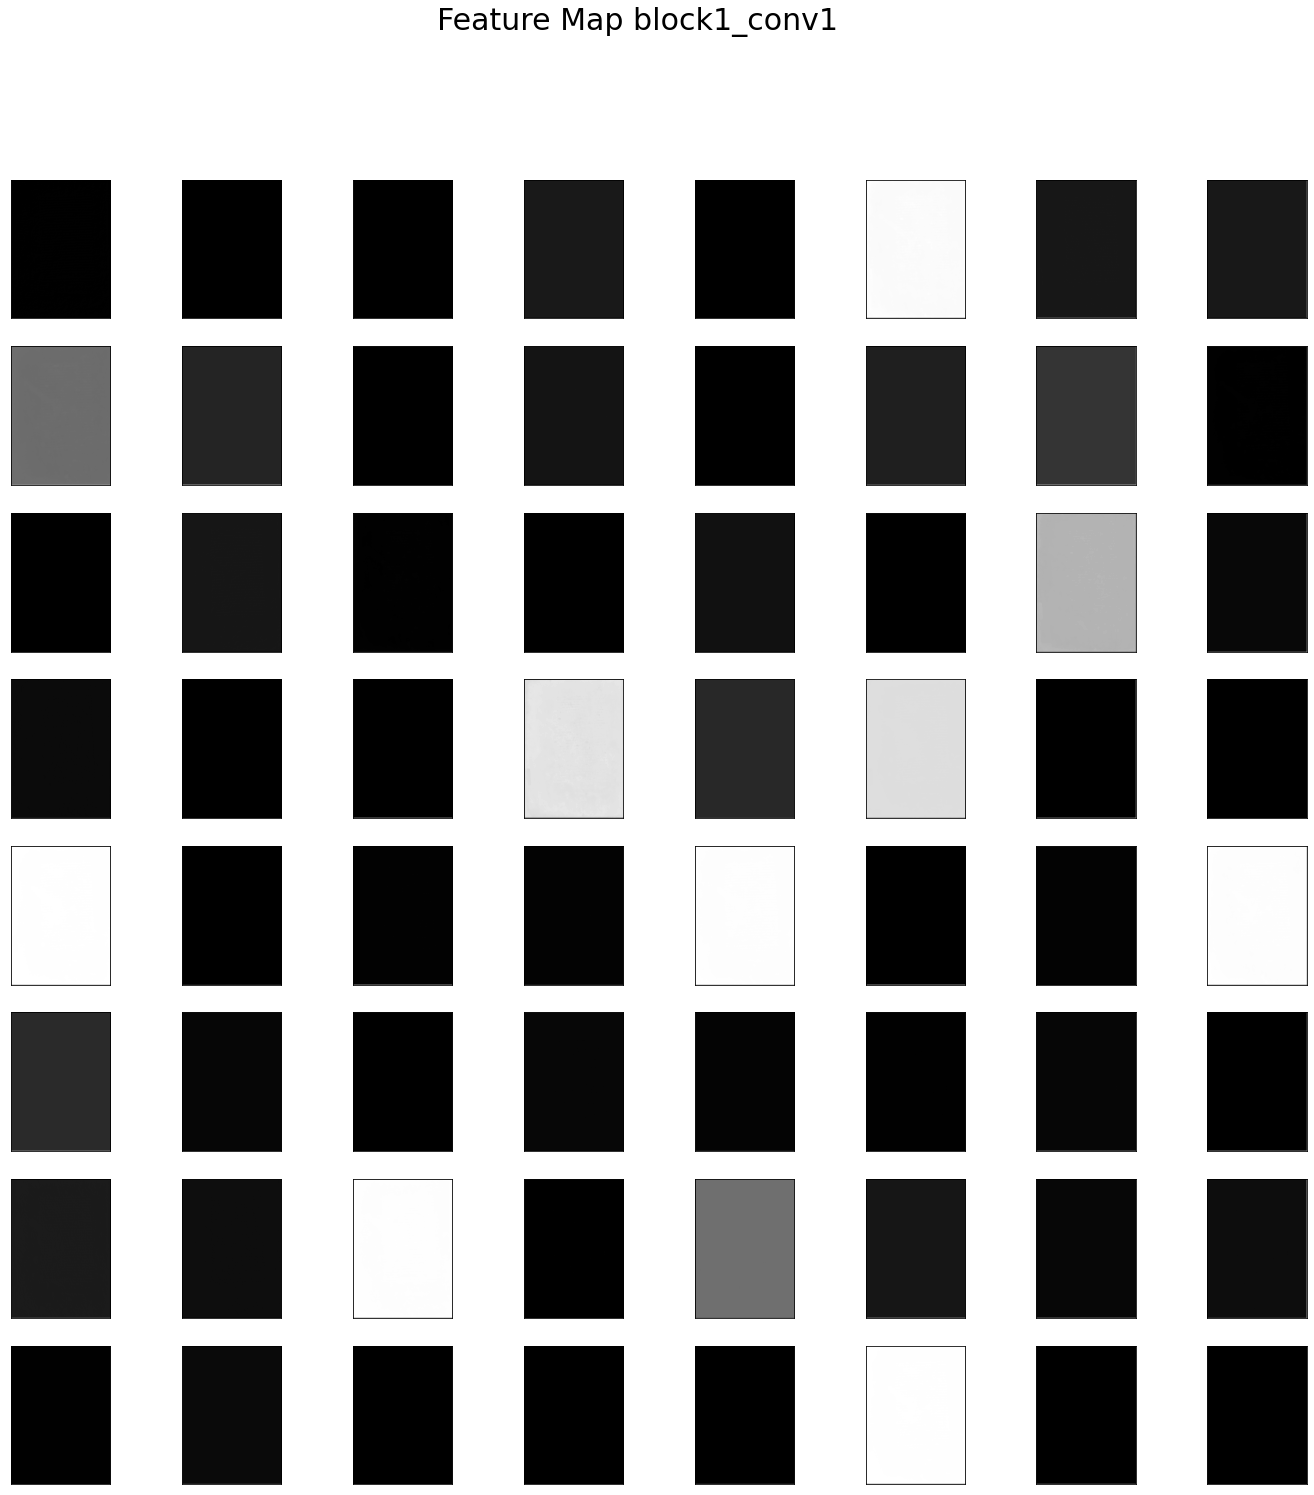

----------------------------------------------------------------------------------------------------


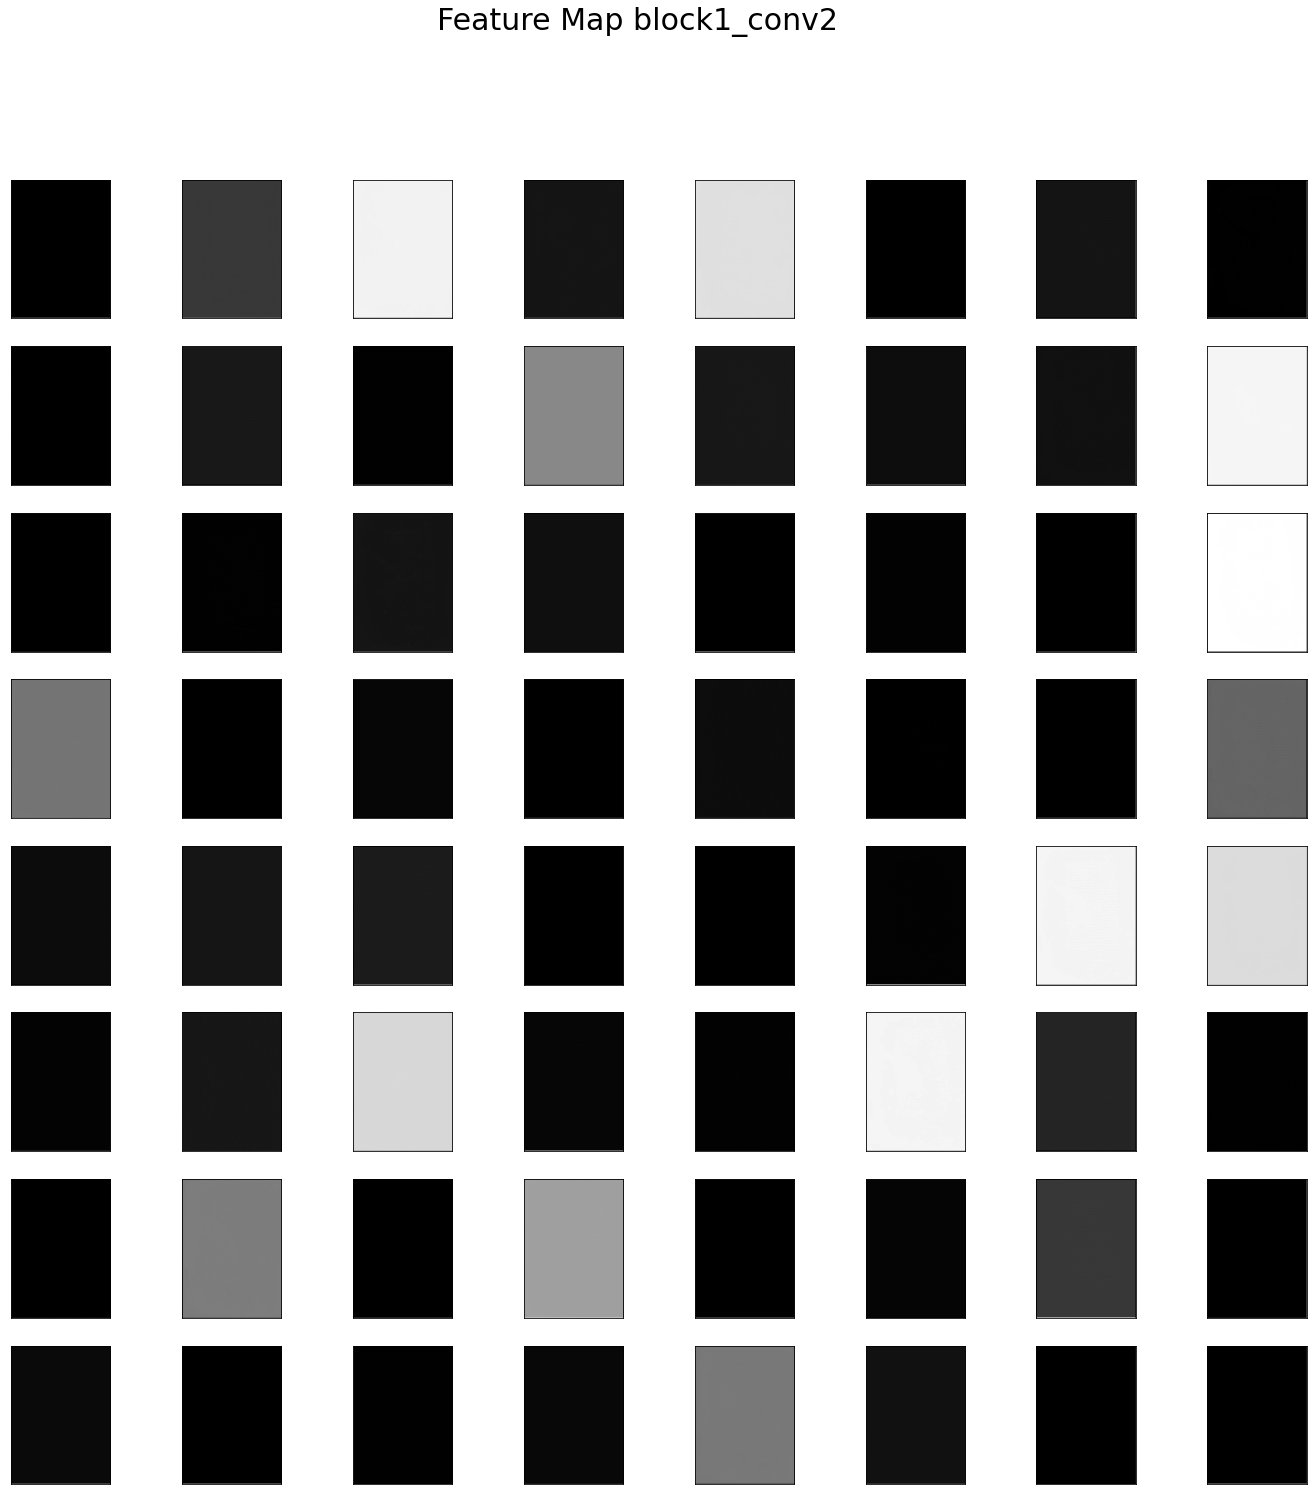

----------------------------------------------------------------------------------------------------


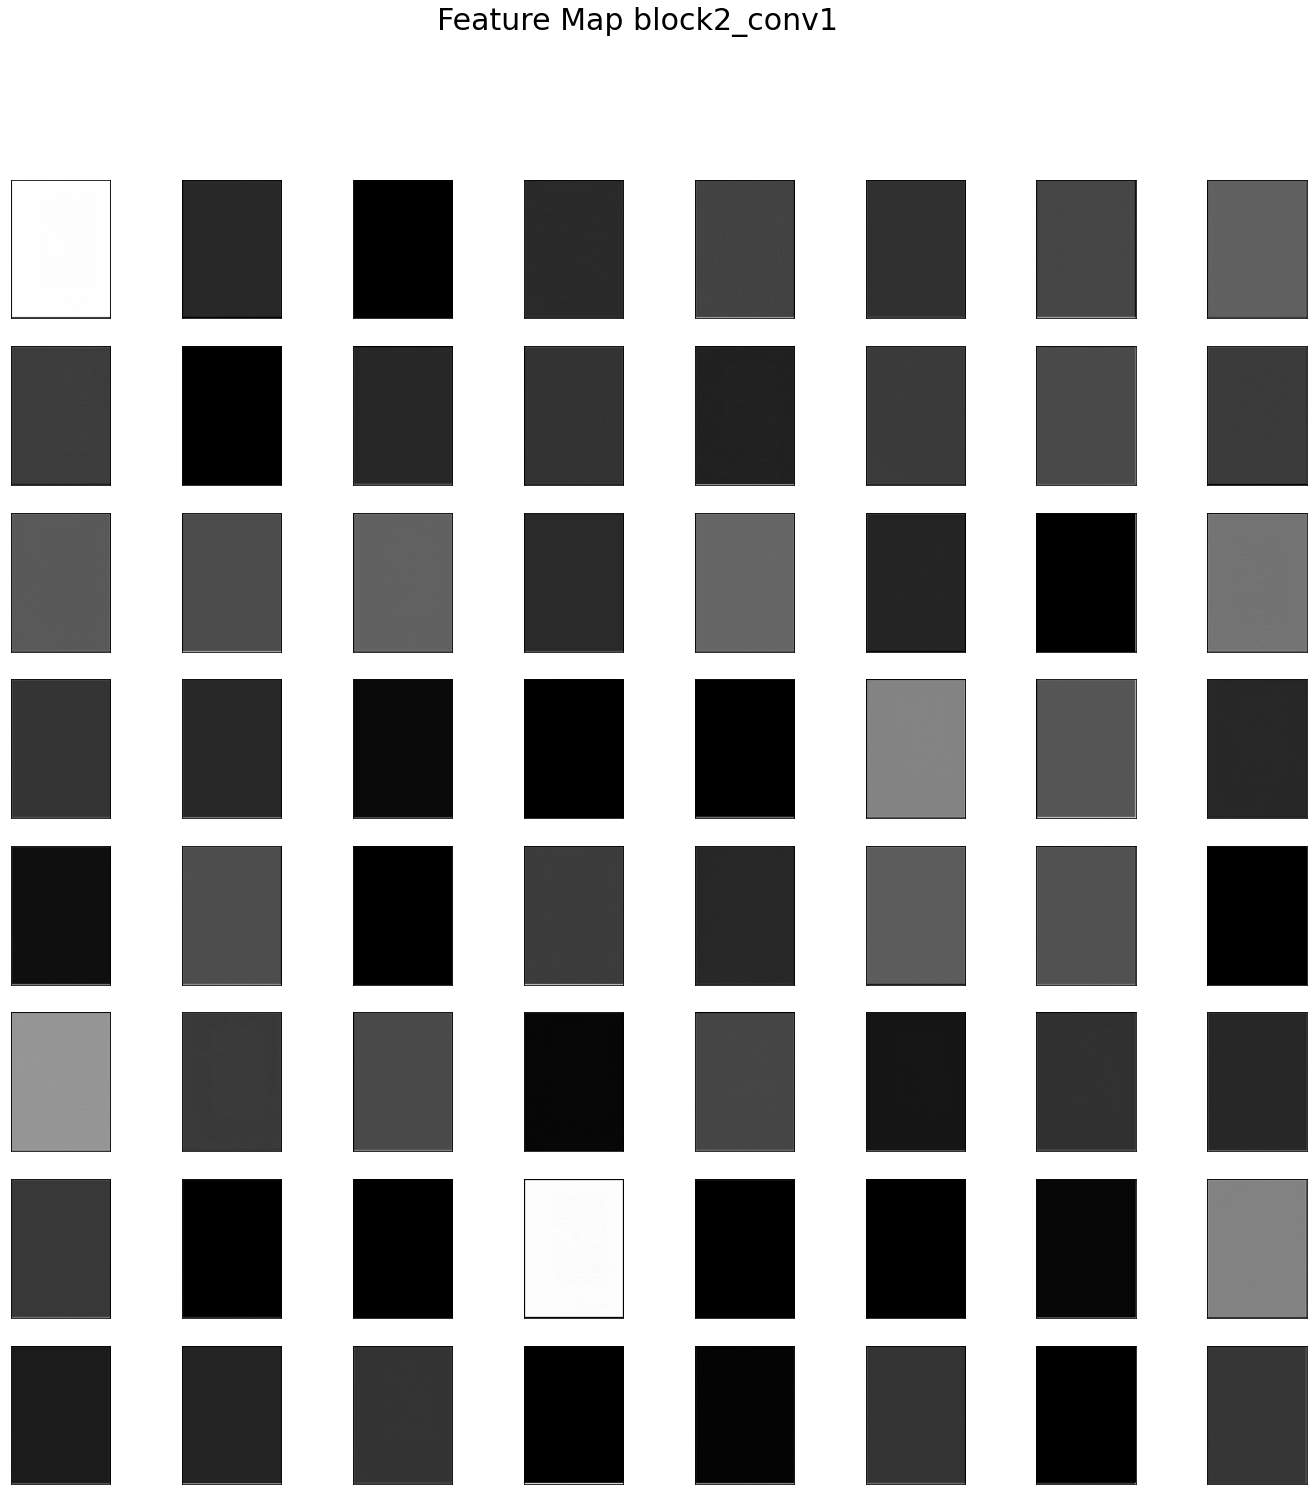

----------------------------------------------------------------------------------------------------


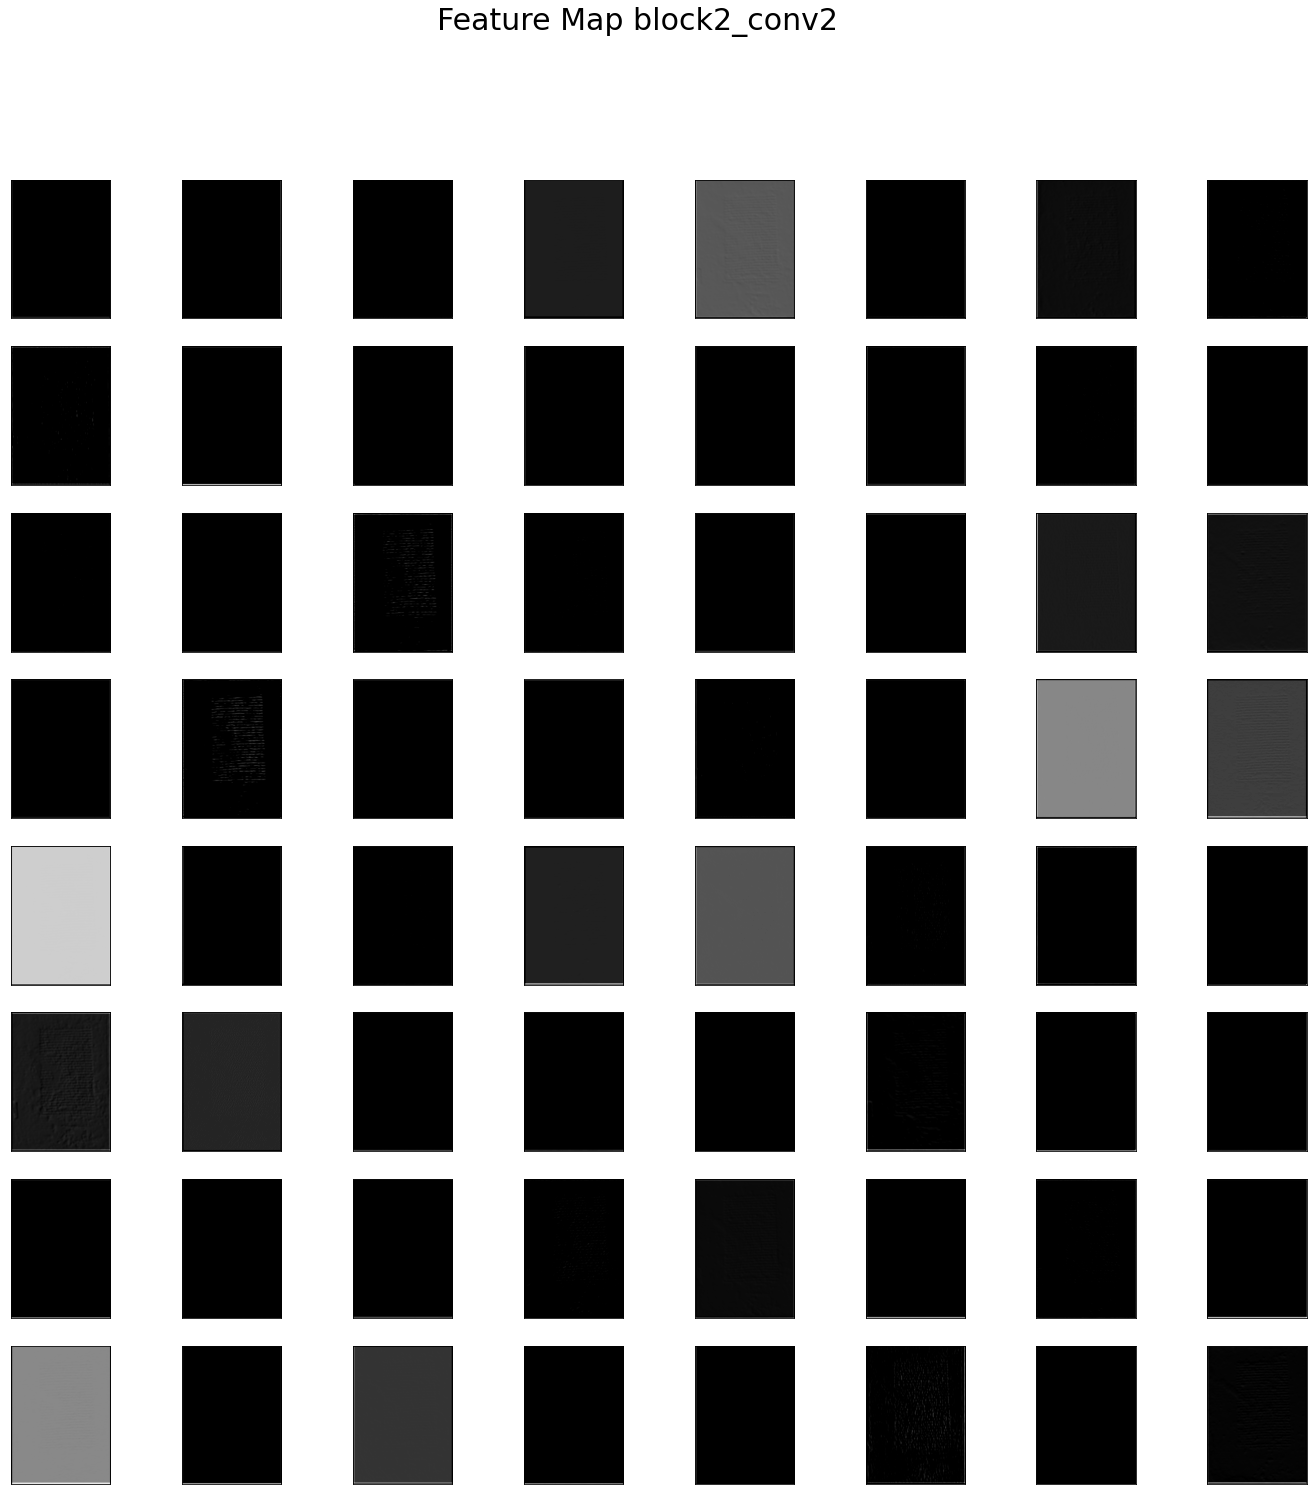

----------------------------------------------------------------------------------------------------


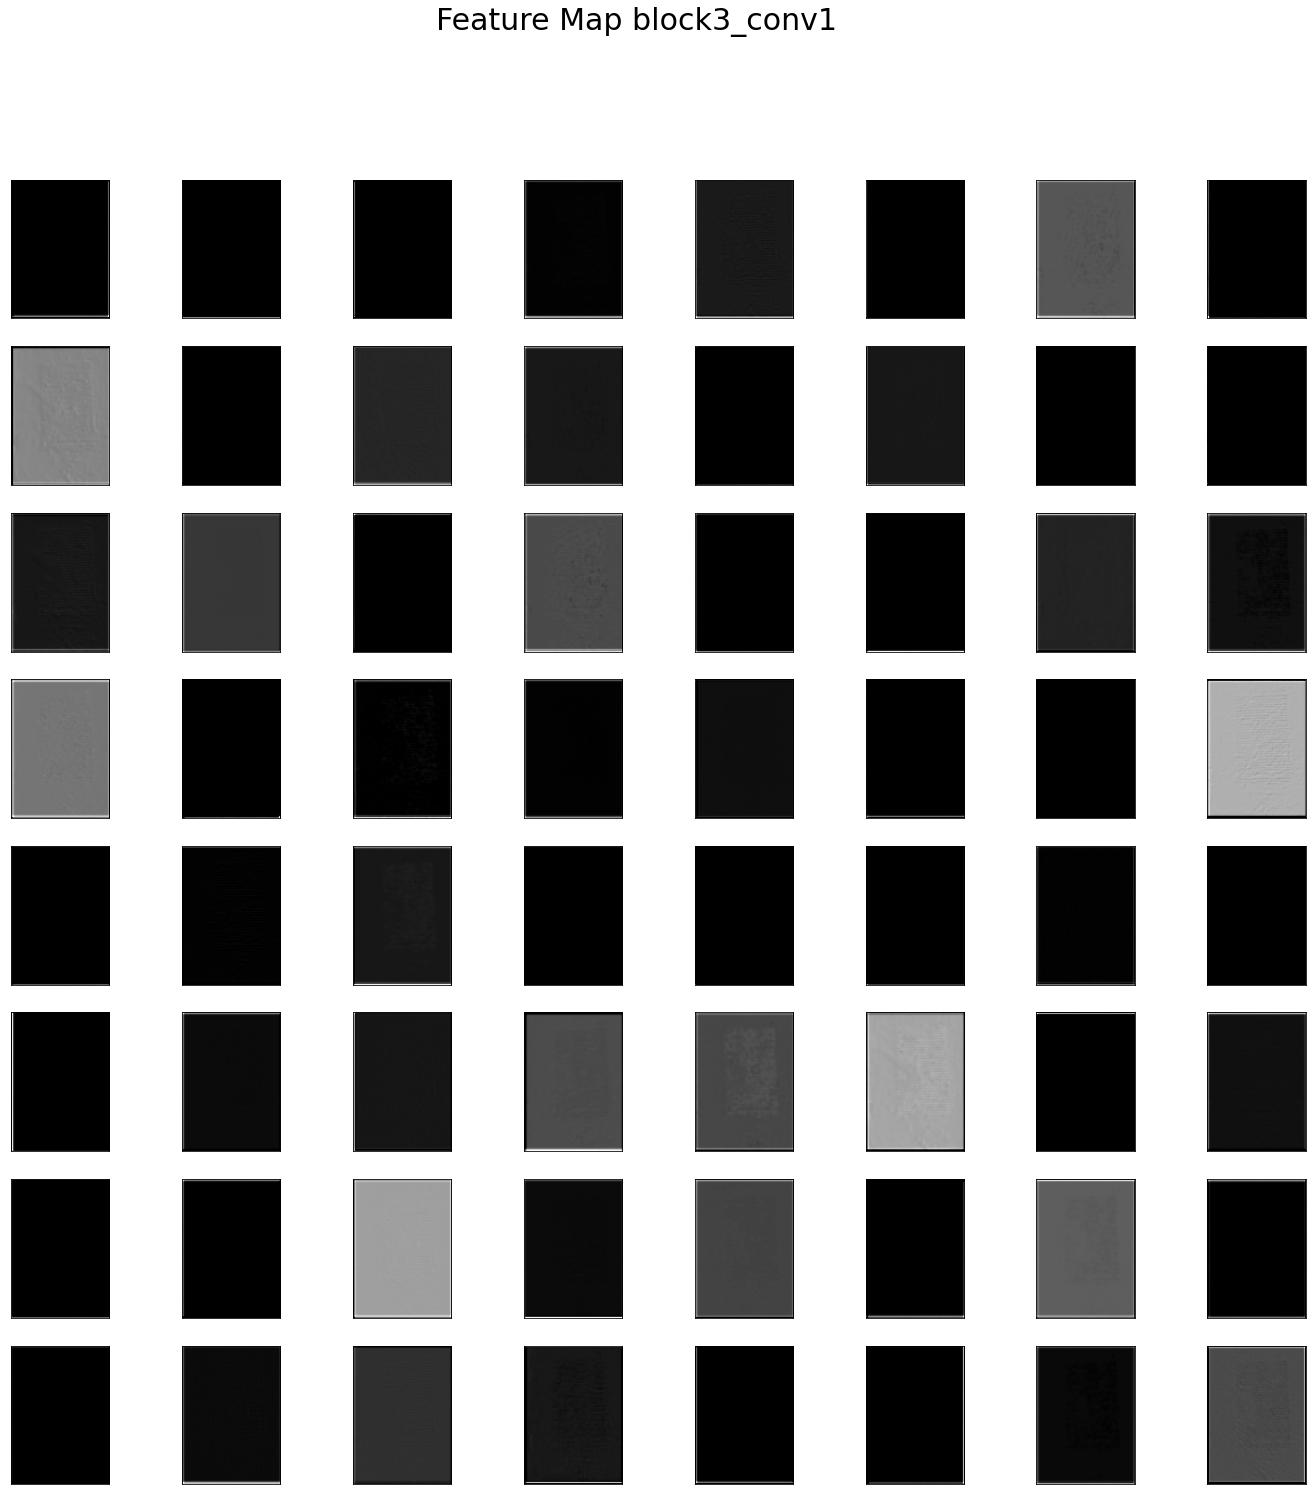

----------------------------------------------------------------------------------------------------


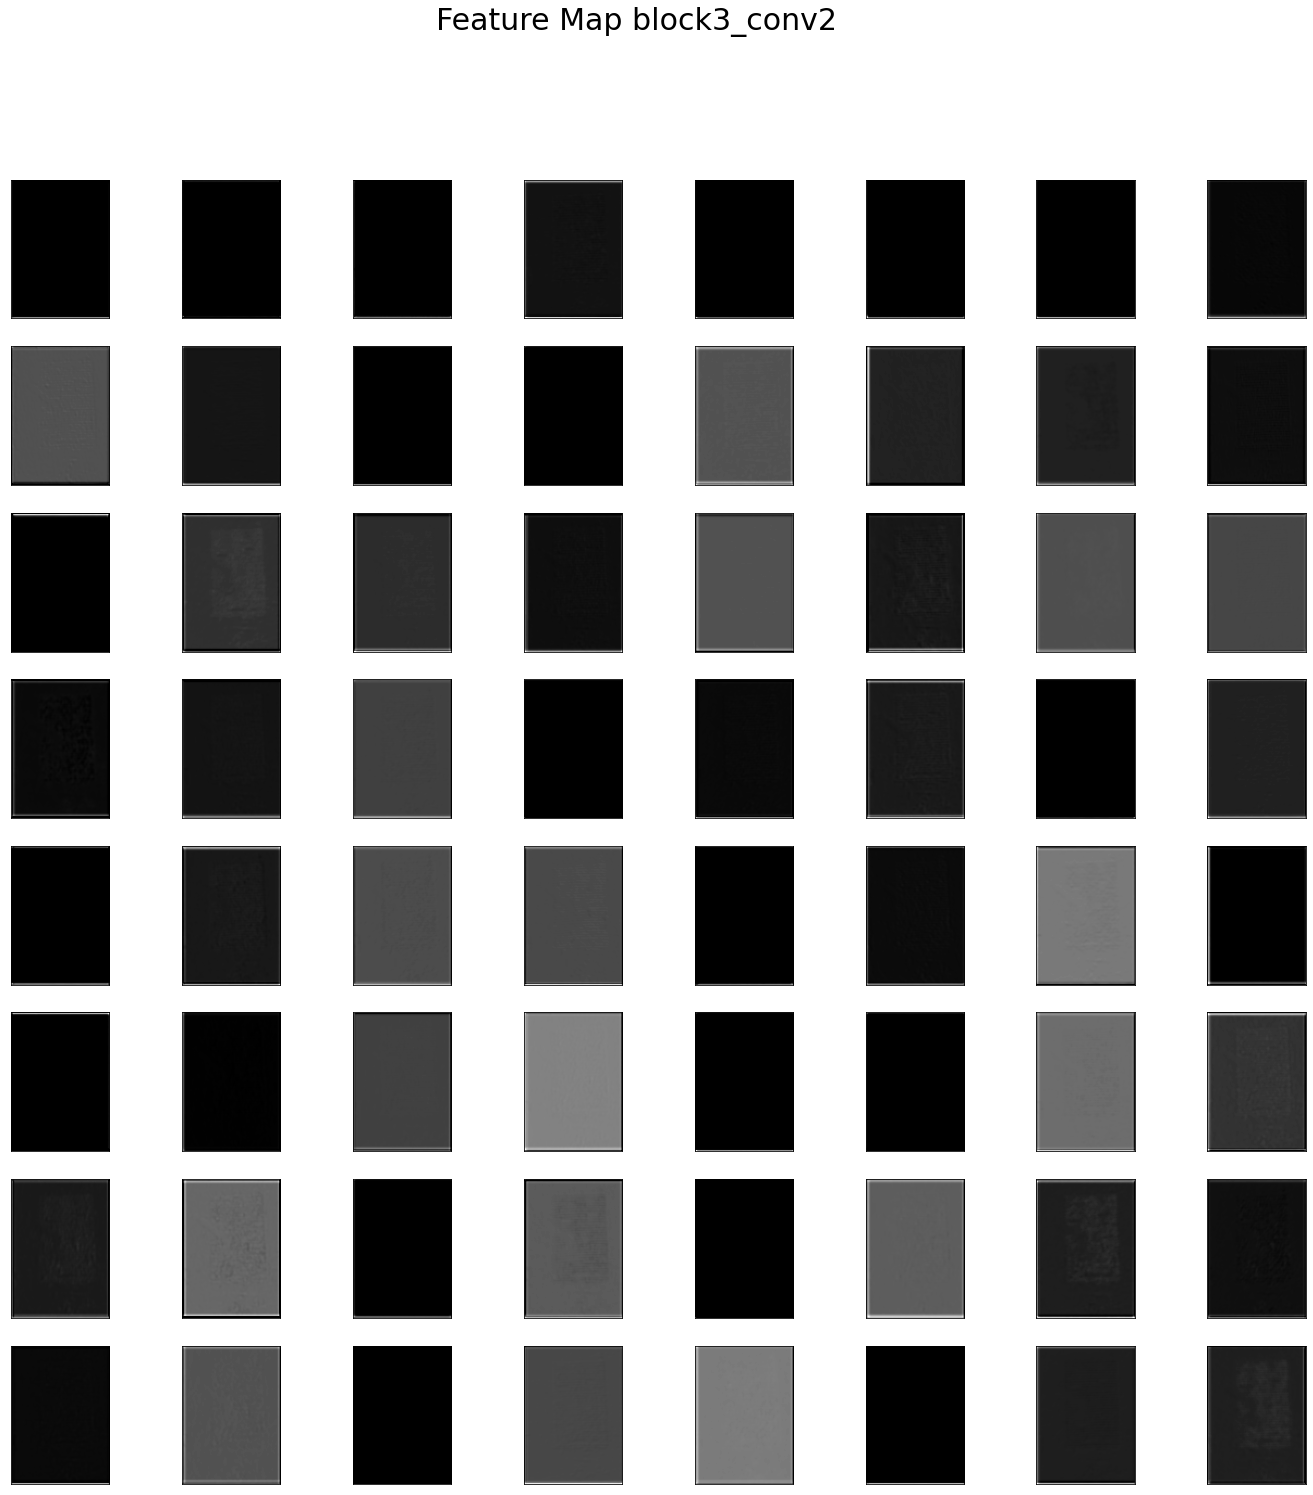

----------------------------------------------------------------------------------------------------


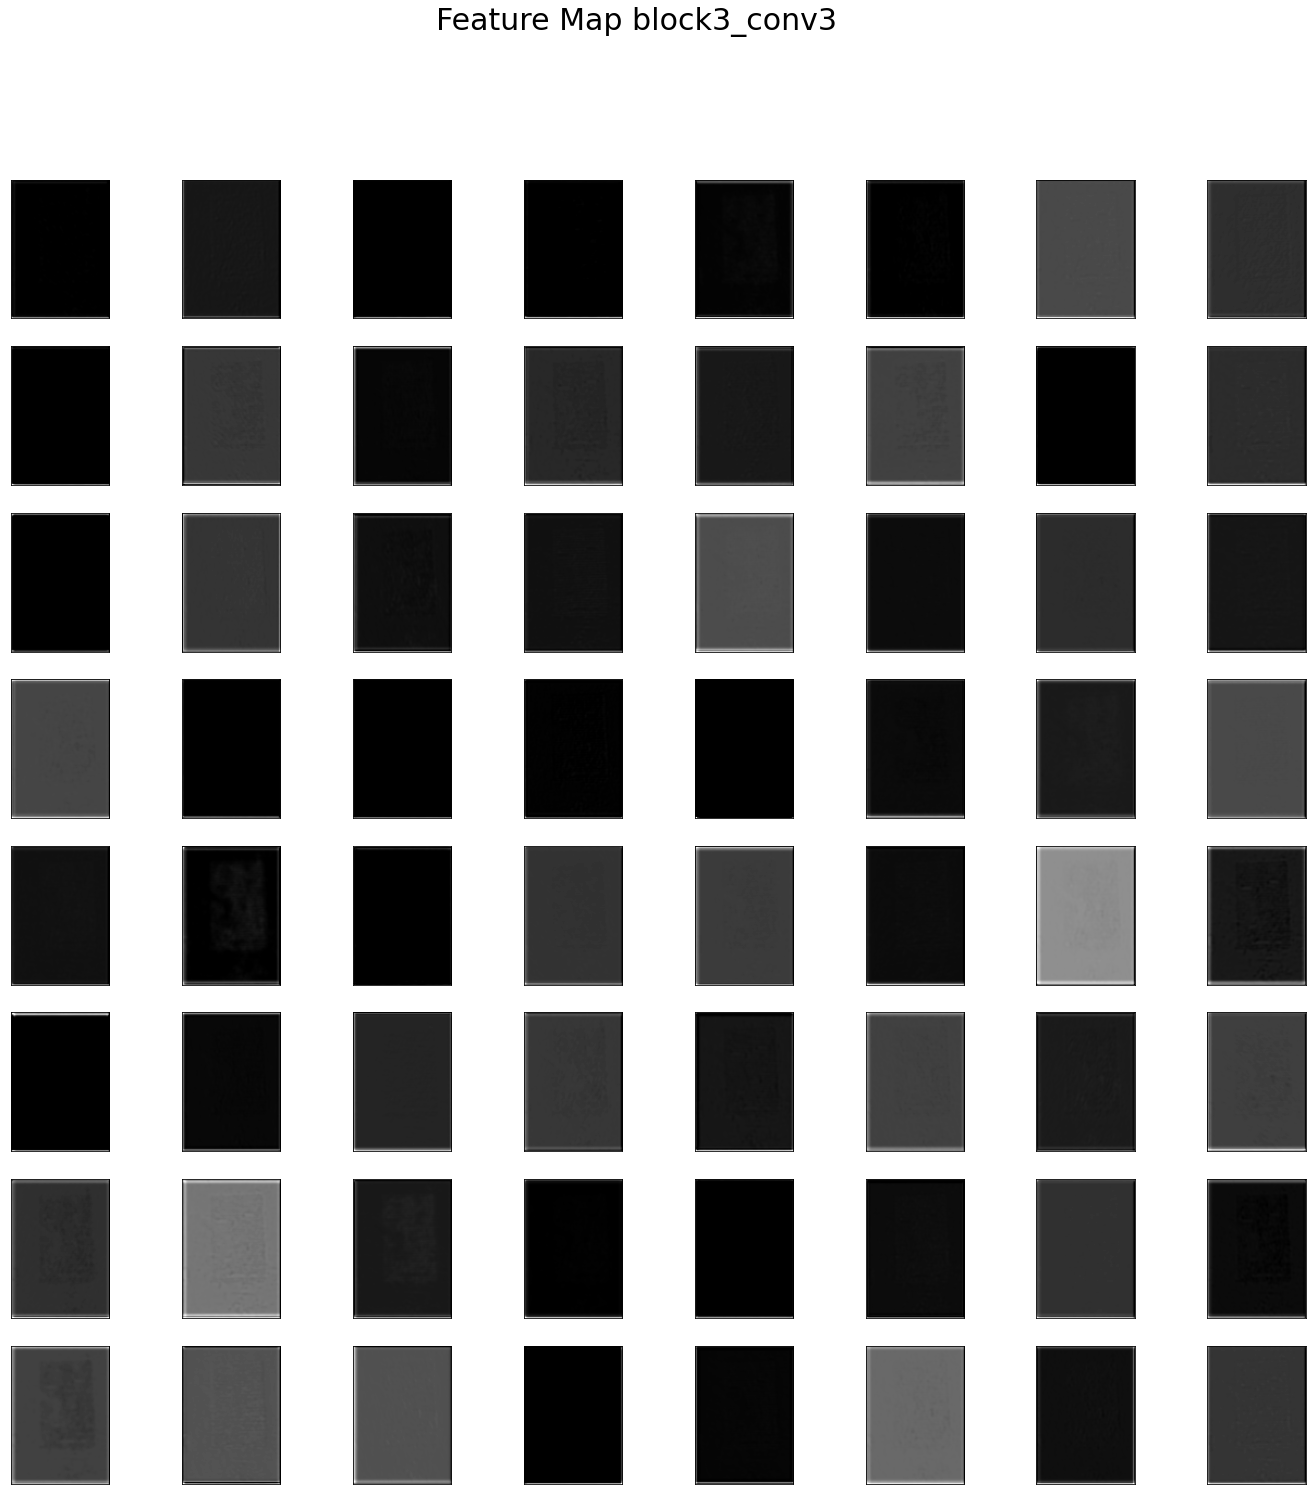

----------------------------------------------------------------------------------------------------


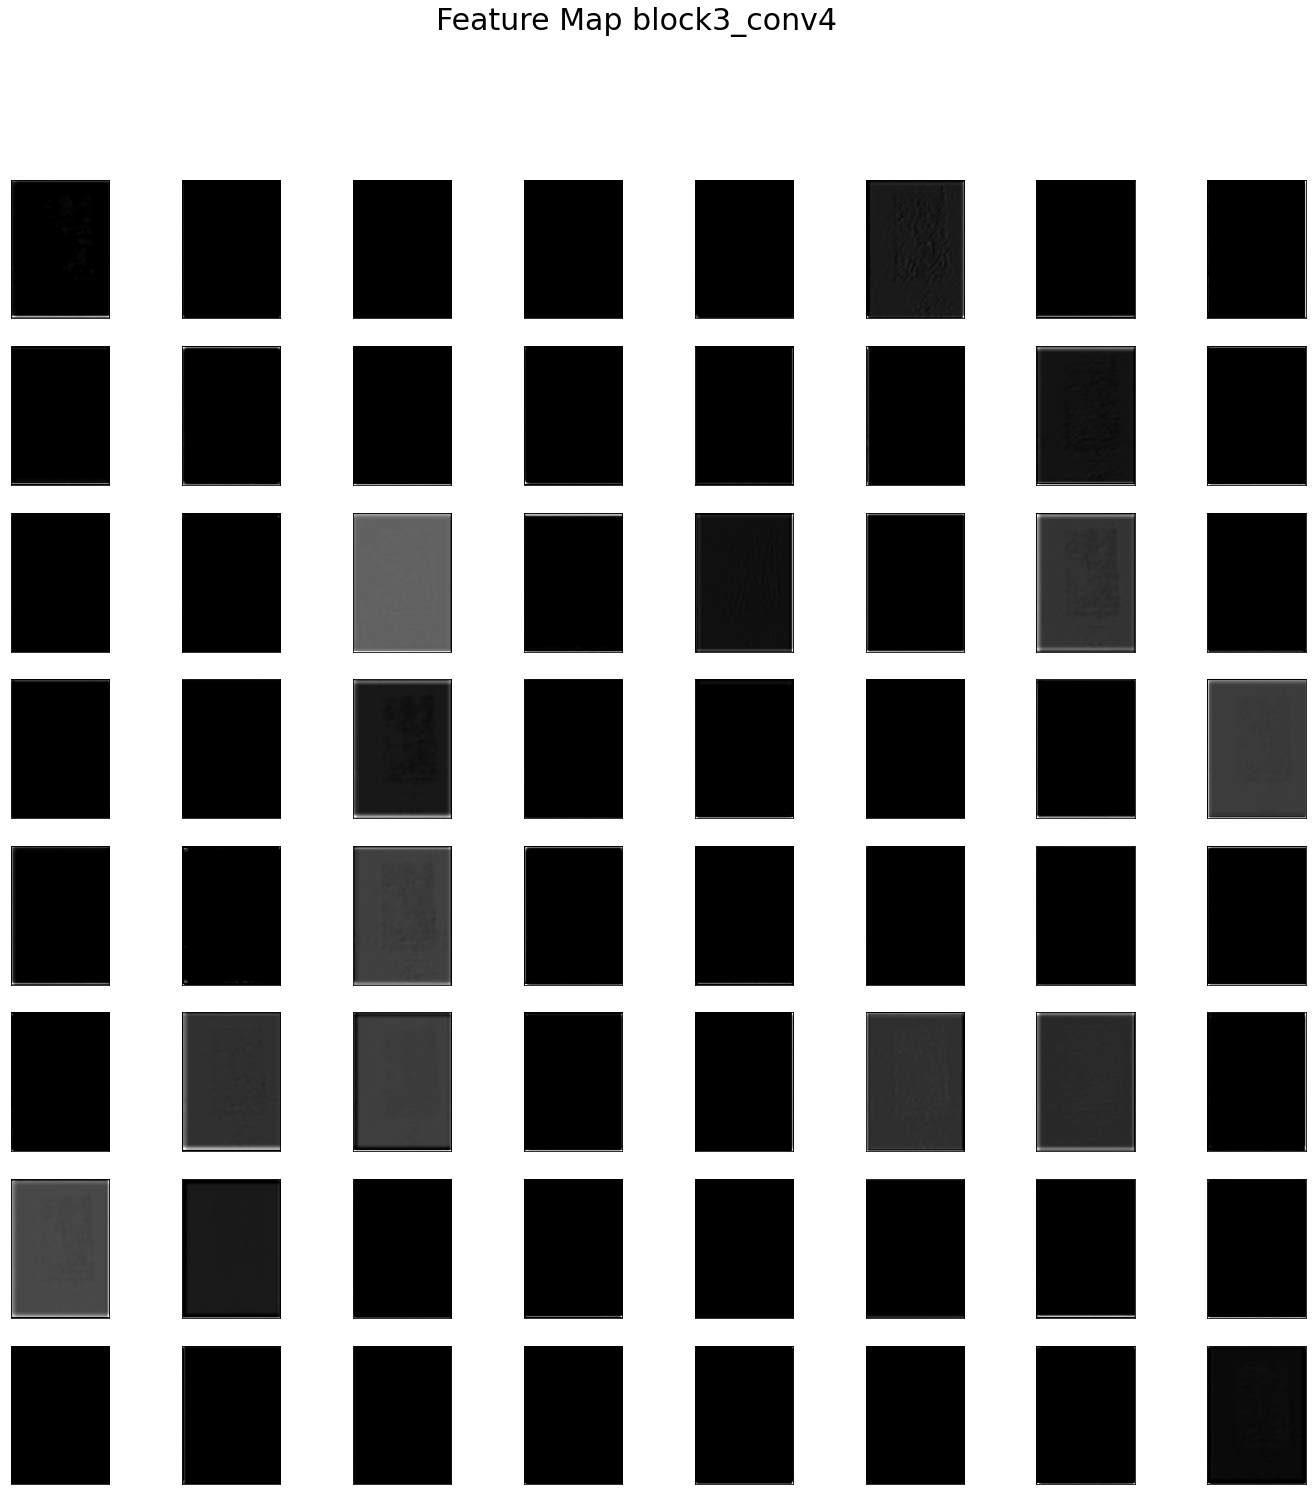

----------------------------------------------------------------------------------------------------


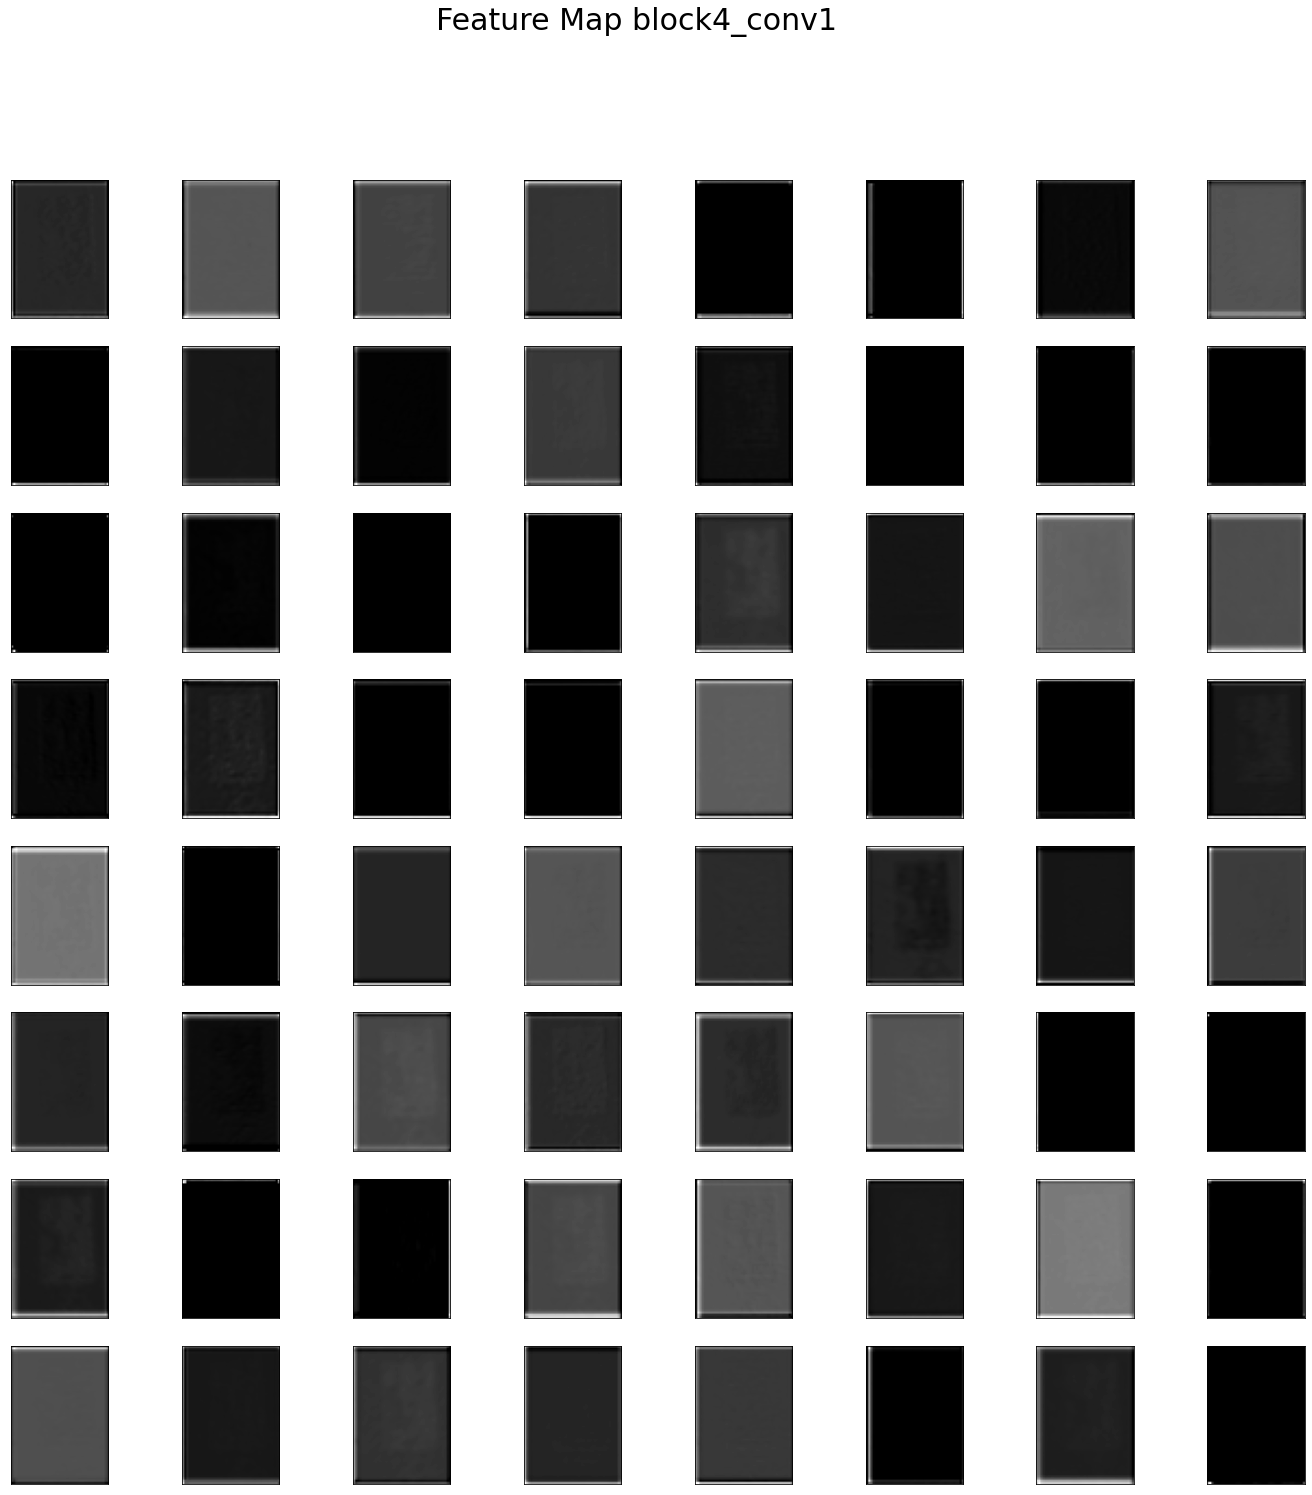

----------------------------------------------------------------------------------------------------


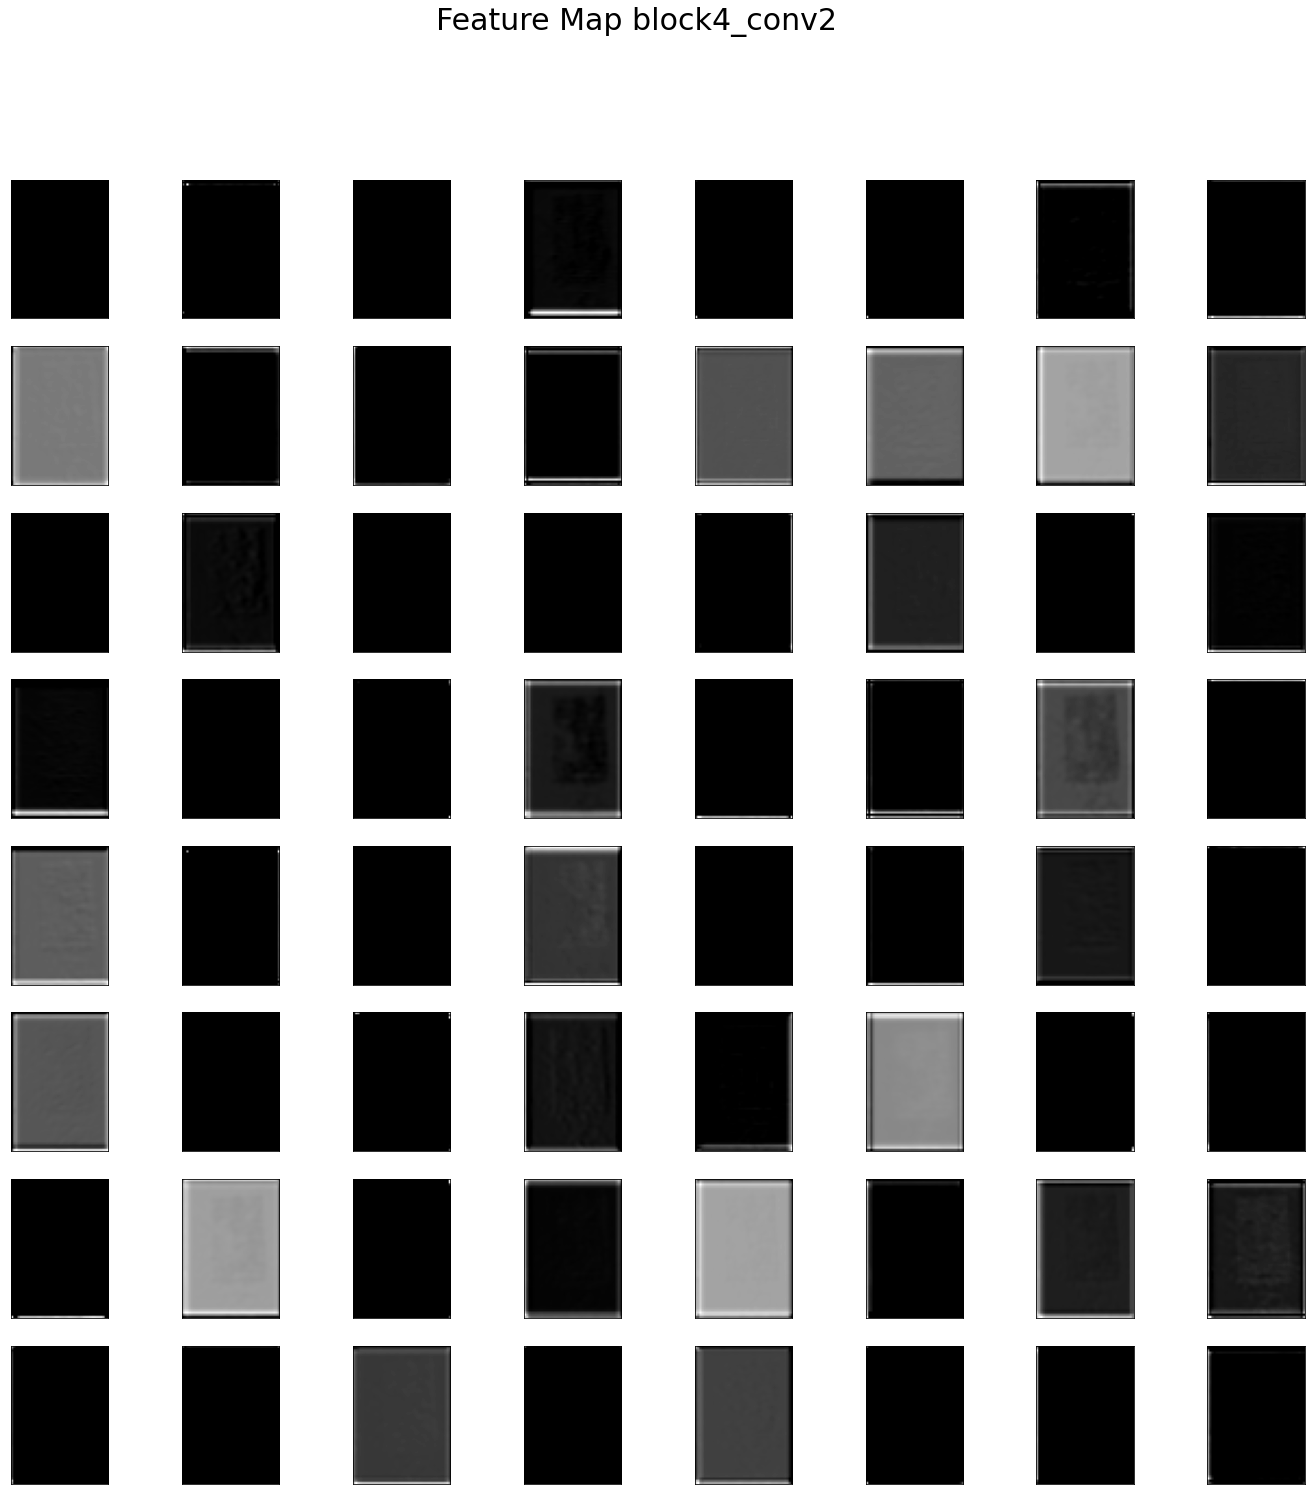

----------------------------------------------------------------------------------------------------


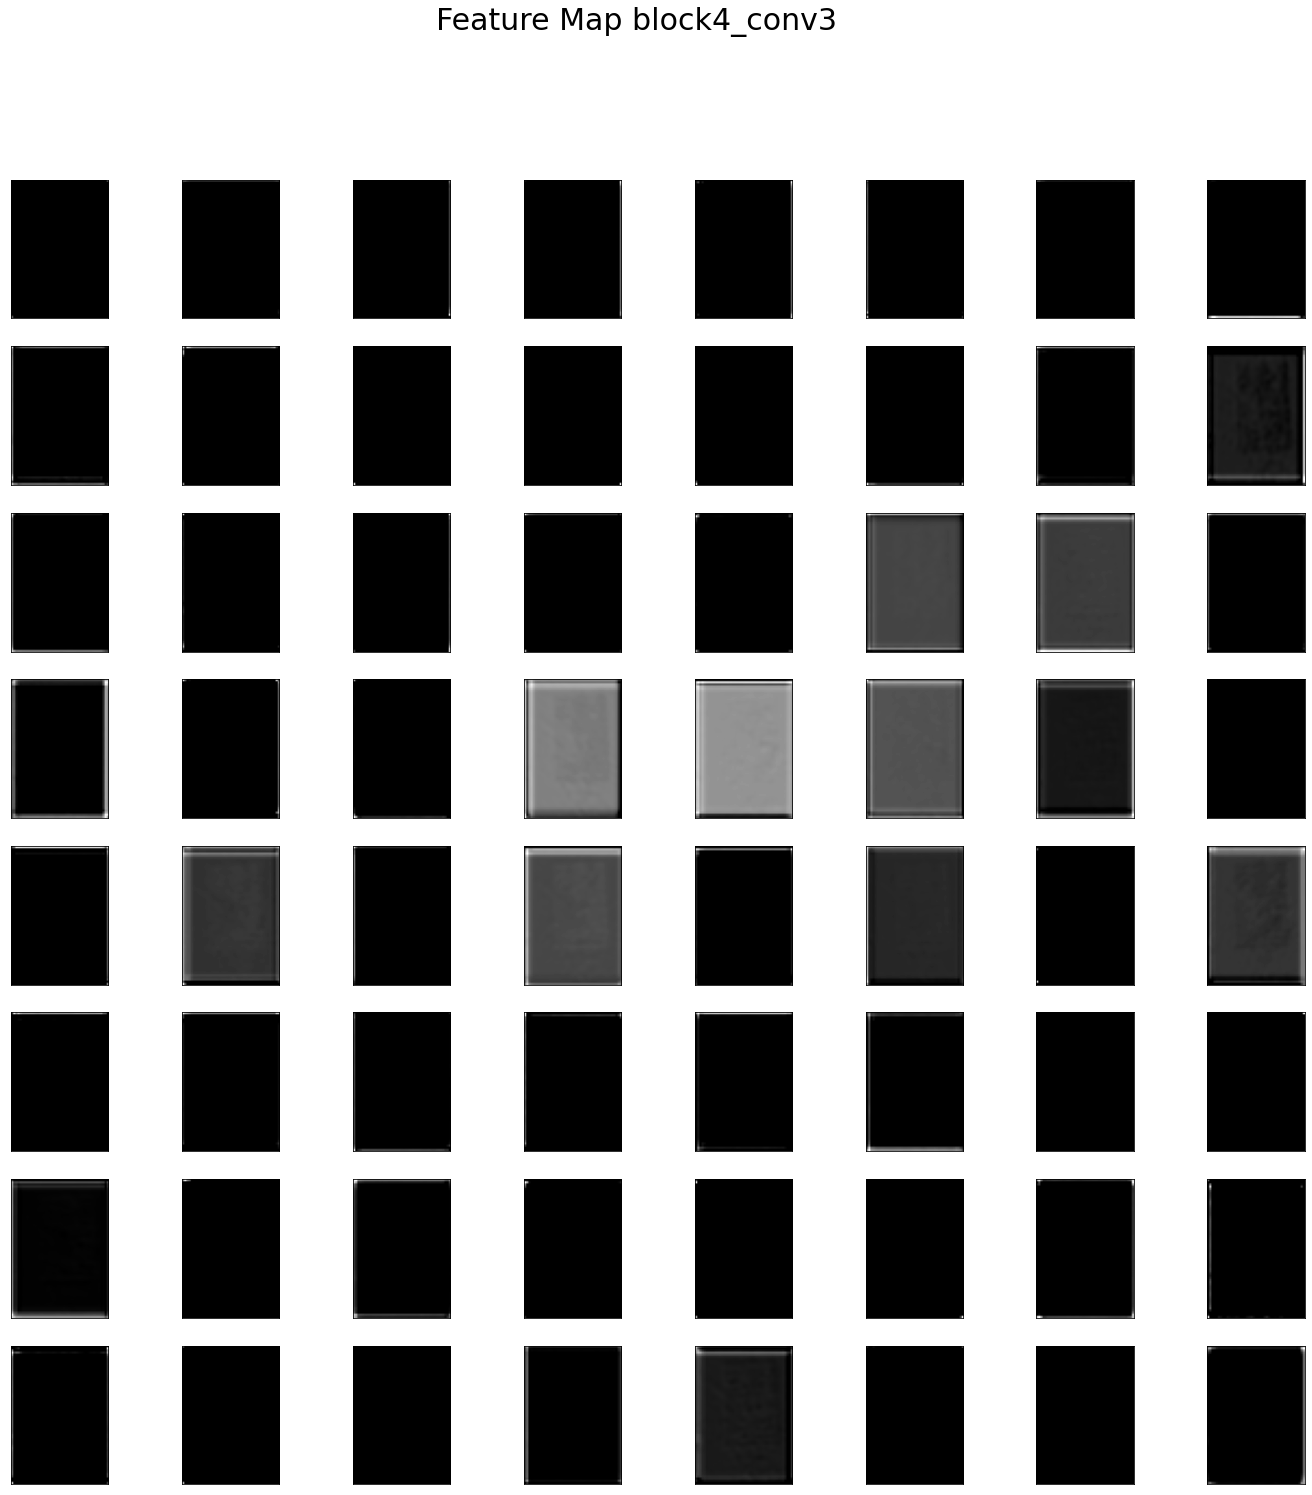

----------------------------------------------------------------------------------------------------


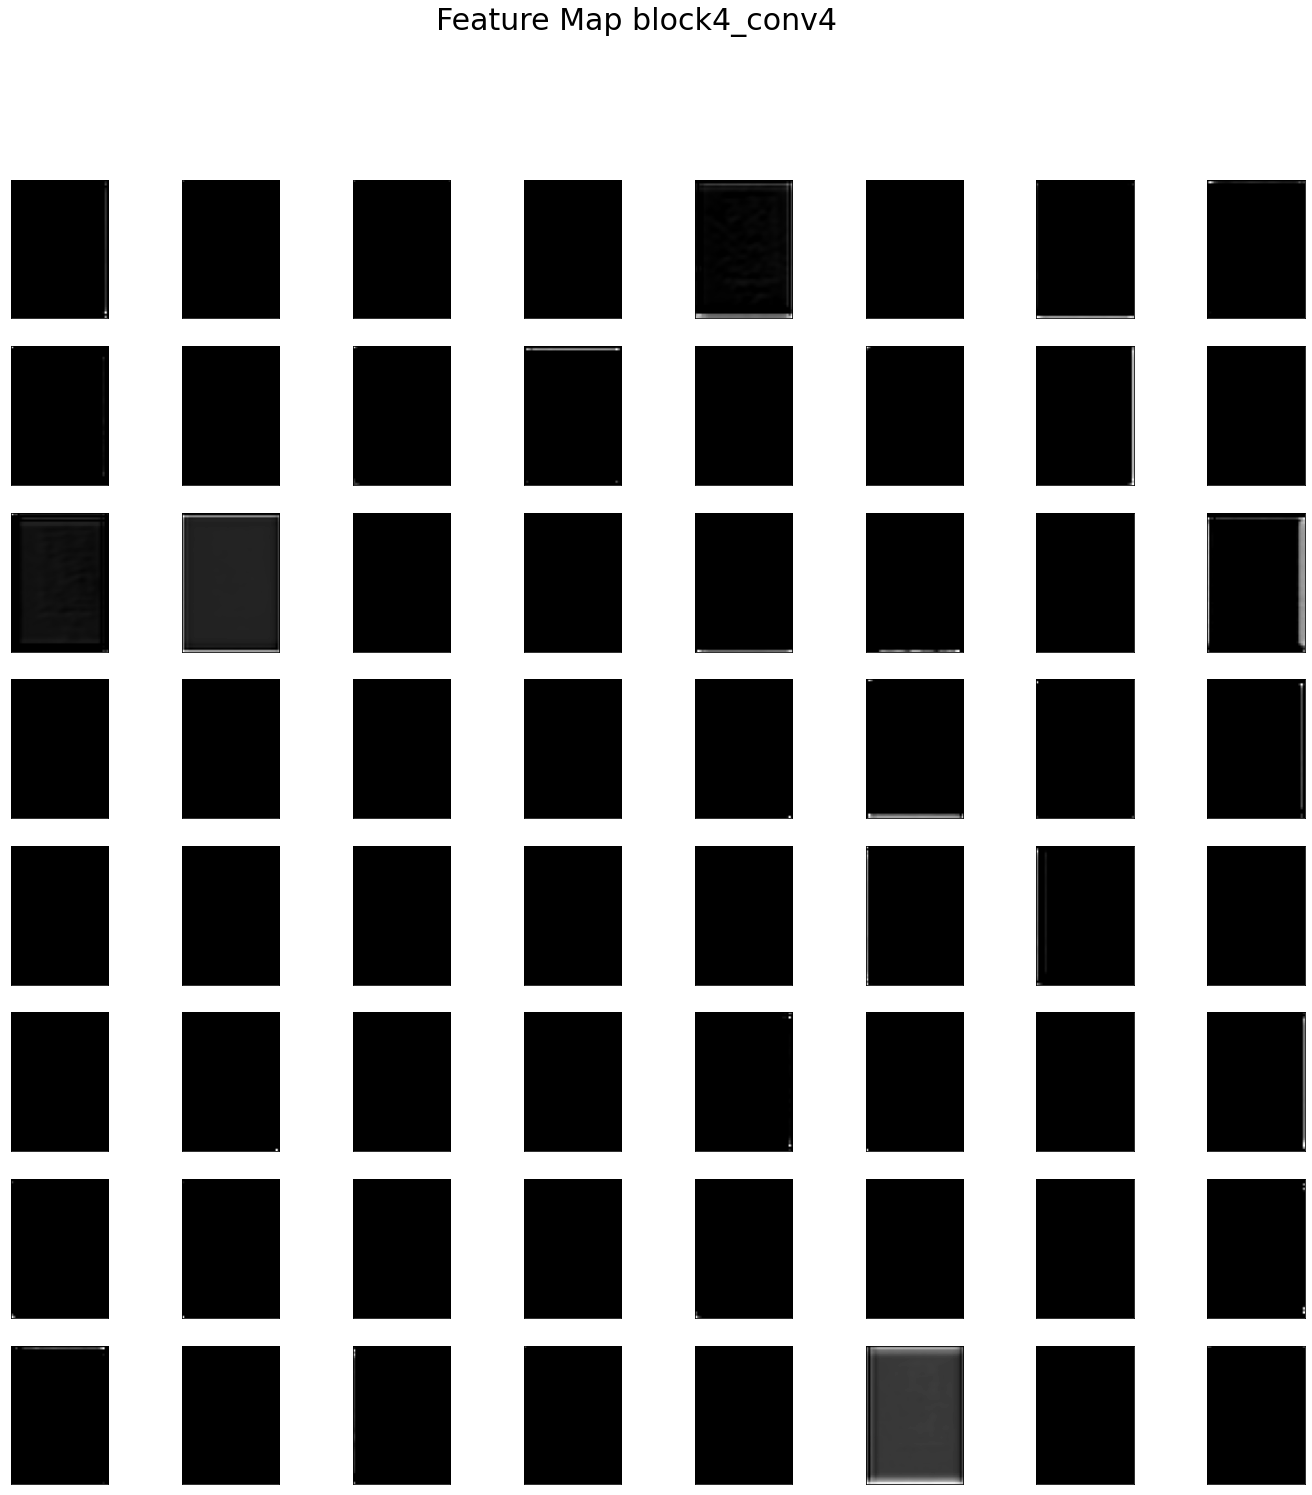

----------------------------------------------------------------------------------------------------


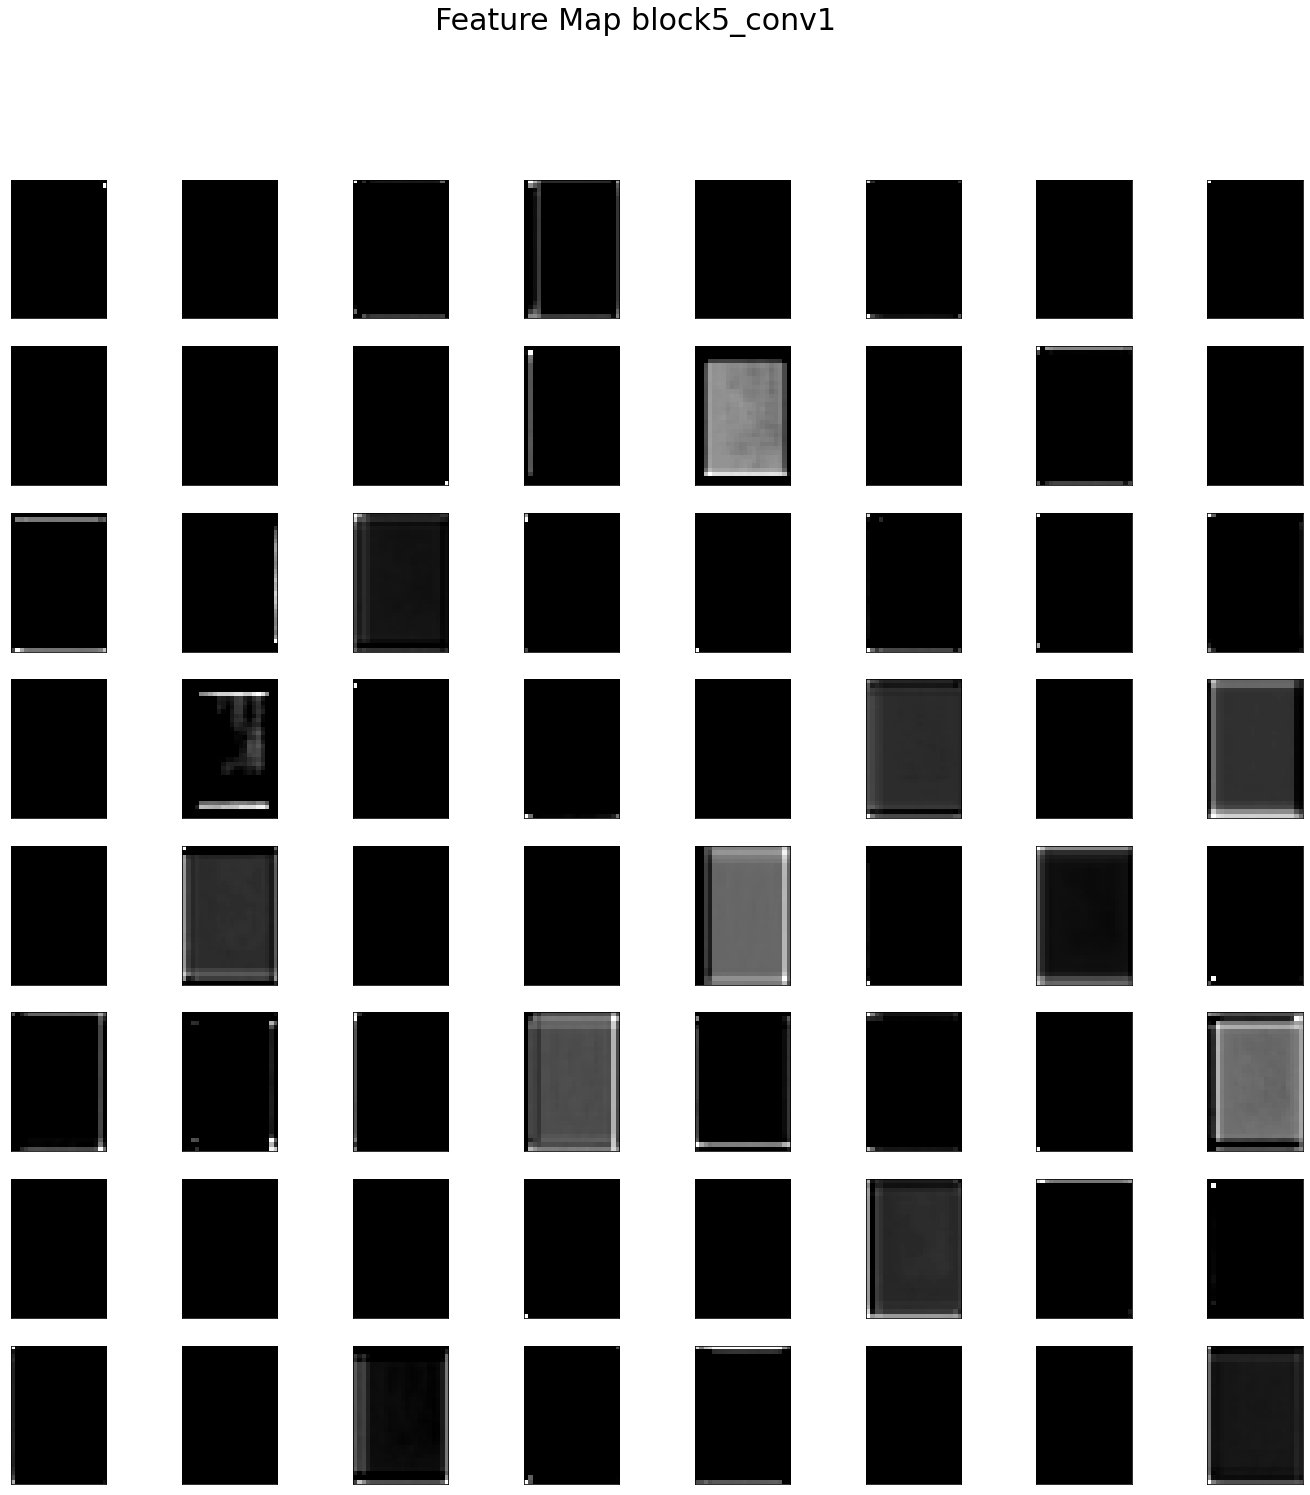

----------------------------------------------------------------------------------------------------


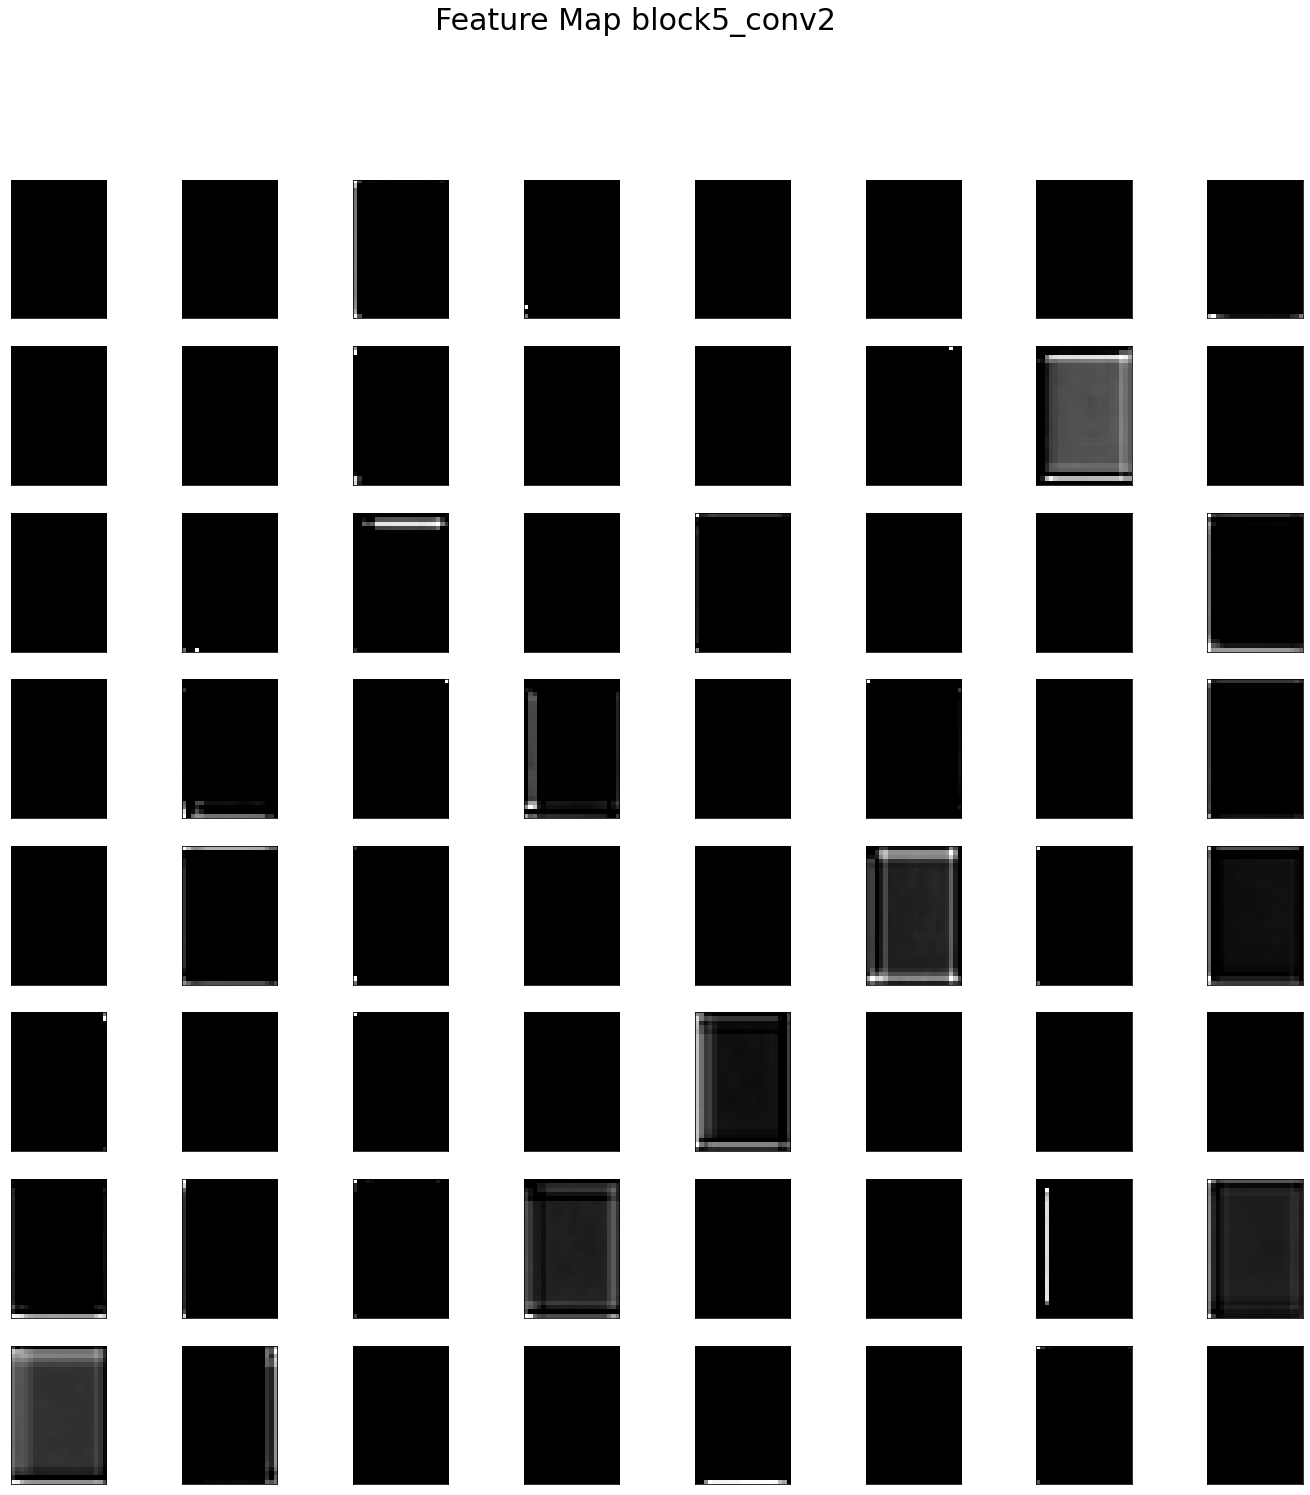

----------------------------------------------------------------------------------------------------


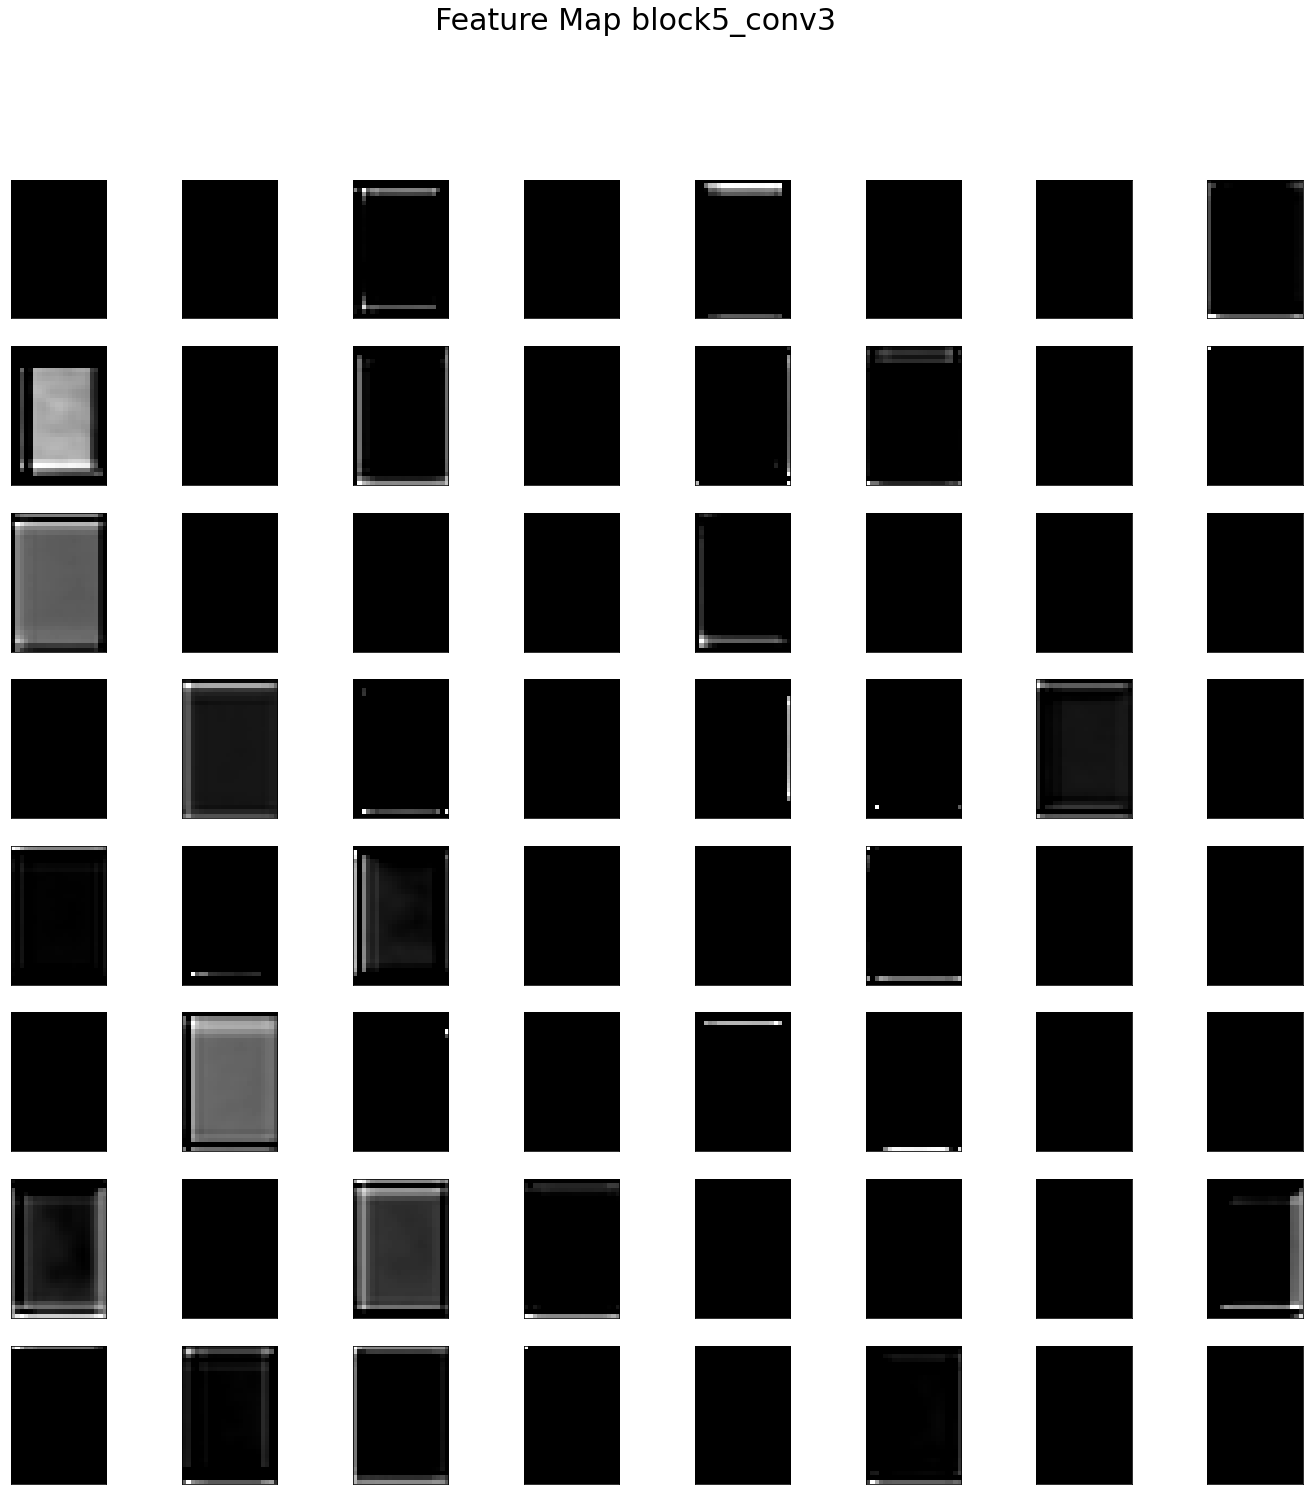

----------------------------------------------------------------------------------------------------


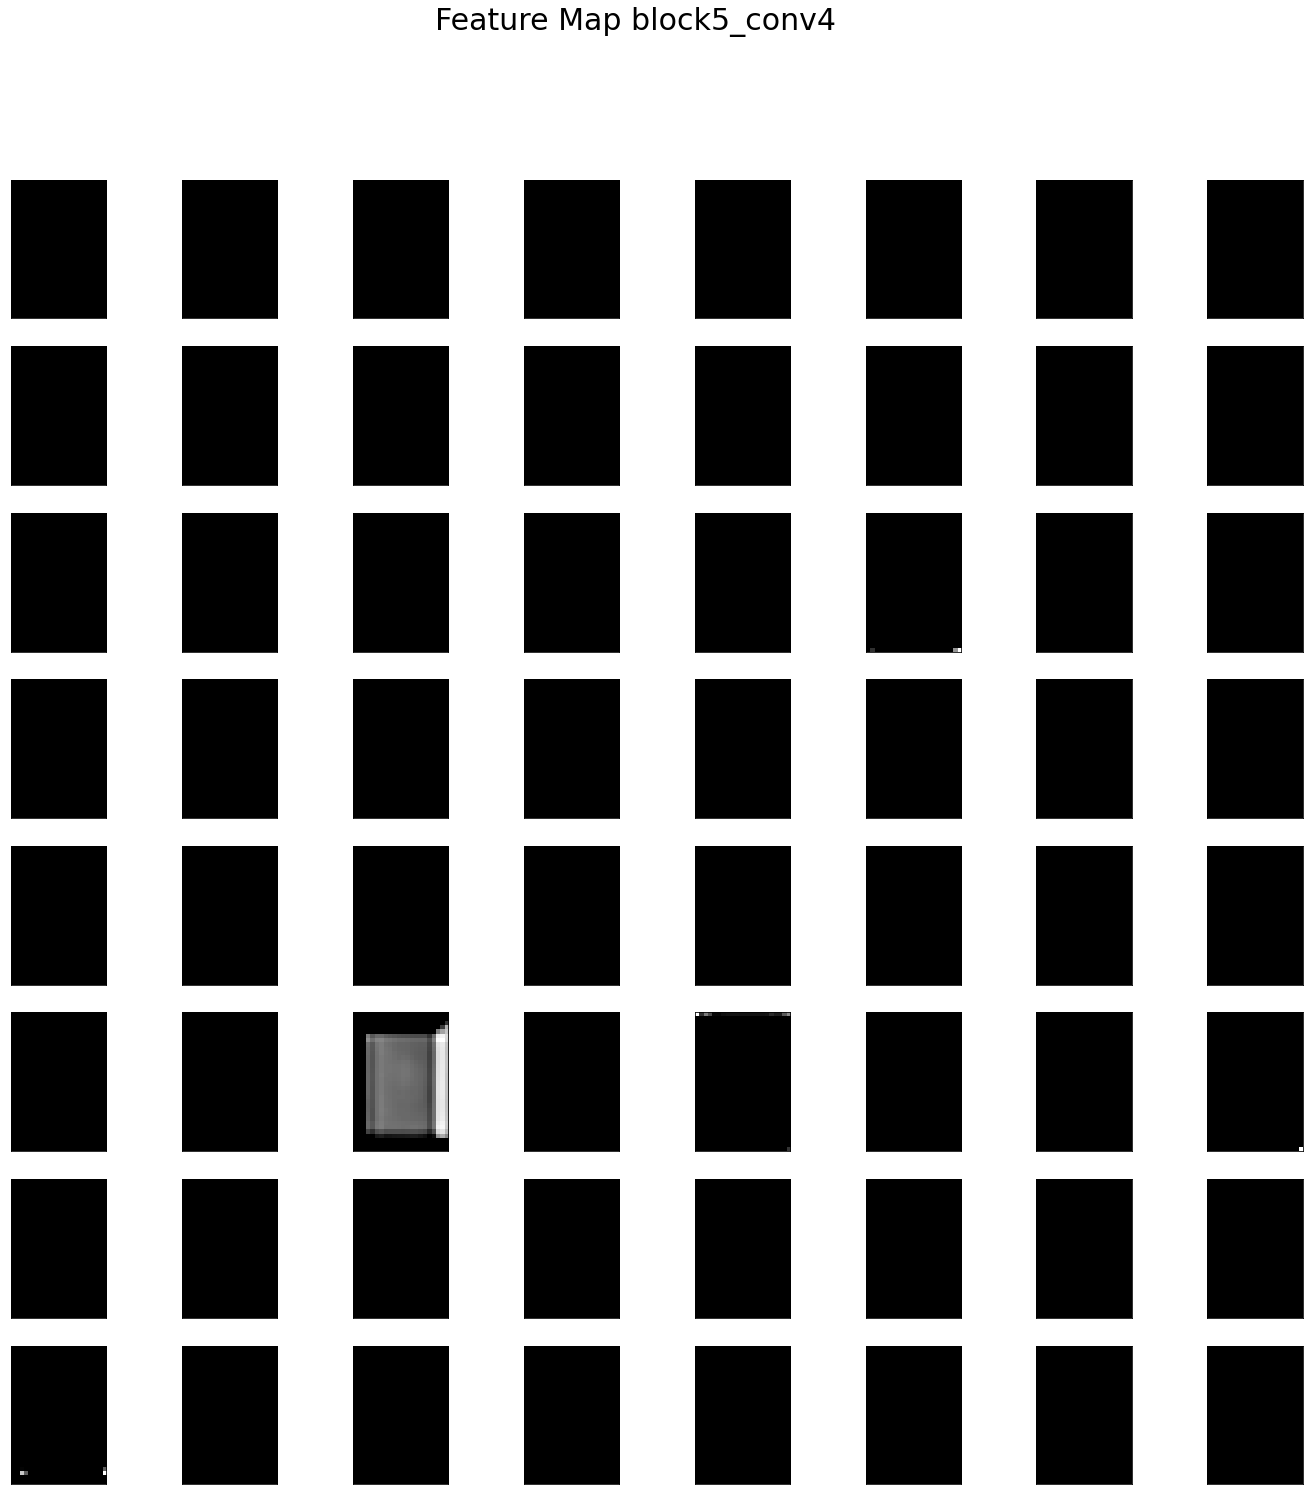

----------------------------------------------------------------------------------------------------


In [13]:
# delete old results
figures_folder_path: str = '/content/style_feature_maps'
if os.path.exists(figures_folder_path):
    shutil.rmtree(figures_folder_path)
os.makedirs(figures_folder_path)

# plot the feature maps
for i in range(0, len(outputs)):
  # we will only show 64 features to get the feeling of the layer
  feature_maps_plot(8, 8, style_feature_maps[i], f"Feature Map {outputs[i]}",
                    figures_folder_path)
  print('-' * 100)

## Zip and Download

In [14]:
!zip -r content_feature_maps_visualization.zip /content/content_feature_maps
!zip -r style_feature_maps_visualization.zip /content/style_feature_maps

from google.colab import files
files.download("/content/content_feature_maps_visualization.zip")
files.download("style_feature_maps_visualization.zip")

  adding: content/content_feature_maps/ (stored 0%)
  adding: content/content_feature_maps/Feature Map block4_conv4.png (deflated 23%)
  adding: content/content_feature_maps/Feature Map block3_conv3.png (deflated 6%)
  adding: content/content_feature_maps/Feature Map block3_conv1.png (deflated 7%)
  adding: content/content_feature_maps/Feature Map block1_conv2.png (deflated 14%)
  adding: content/content_feature_maps/Feature Map block1_conv1.png (deflated 18%)
  adding: content/content_feature_maps/Feature Map block5_conv2.png (deflated 37%)
  adding: content/content_feature_maps/Feature Map block5_conv1.png (deflated 32%)
  adding: content/content_feature_maps/Feature Map block2_conv1.png (deflated 8%)
  adding: content/content_feature_maps/Feature Map block3_conv4.png (deflated 9%)
  adding: content/content_feature_maps/Feature Map block2_conv2.png (deflated 9%)
  adding: content/content_feature_maps/Feature Map block3_conv2.png (deflated 6%)
  adding: content/content_feature_maps/Fe

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>